In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cholesky
from numpy.random import normal

# For Portfolio Optimization and Monte Carlo VaR
from scipy.optimize import minimize

In [4]:
# Step 1: Load NIFTY 50 data from CSVs
import os

# Assuming the directory 'nifty_50_csv' contains the CSV files for each NIFTY 50 stock
data_path = 'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017'
stock_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Create a dictionary to store stock data
stock_data = {}

# Load each CSV file
for stock_file in stock_files:
    stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
    stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))

# Combine closing prices for all stocks
close_prices = pd.DataFrame()
for stock, df in stock_data.items():
    close_prices[stock] = df['Close']

# Step 2: Calculate daily returns
returns = close_prices.pct_change().dropna()

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\14913401.py:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


In [5]:
returns = close_prices.pct_change().dropna()


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\3754976312.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


In [6]:
# Step 3: Portfolio Optimization - Markowitz Efficient Frontier
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights should be 1
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Minimize the variance (risk) given a set return
    def minimize_variance(weights):
        return portfolio_variance(weights, cov_matrix)

    result = minimize(minimize_variance, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [7]:
mean_returns = returns.mean()
cov_matrix = returns.cov()


In [8]:
# Optimizing the portfolio
optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

# Get the optimal weights, returns, and risk (variance)
optimal_weights = optimal_portfolio['x']
optimal_return = portfolio_return(optimal_weights, mean_returns)
optimal_variance = portfolio_variance(optimal_weights, cov_matrix)

In [9]:
print(f"Optimal Portfolio Weights: {optimal_weights}")
print(f"Optimal Portfolio Return: {optimal_return}")
print(f"Optimal Portfolio Variance: {optimal_variance}")

Optimal Portfolio Weights: [2.06814305e-02 2.26528826e-02 2.21962435e-02 2.24586819e-02
 2.06161126e-02 2.27237906e-02 2.23339990e-02 2.60208521e-18
 2.19036213e-02 9.77568951e-03 2.22826475e-02 3.28779998e-04
 2.31700716e-02 2.27993657e-02 2.15712283e-02 8.61711541e-04
 9.42305155e-03 2.27548495e-02 2.14805460e-02 2.30800049e-02
 2.22400714e-02 2.06132719e-02 2.17813866e-02 2.13962062e-02
 2.17349461e-02 2.10287860e-02 2.18650895e-02 2.21132200e-02
 1.68198956e-02 2.24741411e-02 2.17050854e-02 2.29986668e-02
 2.31712341e-02 2.06814305e-02 2.31328715e-02 2.00686763e-02
 2.31040255e-02 1.85729278e-02 2.31456651e-02 2.15589567e-02
 2.16580438e-02 2.12793828e-02 2.02469031e-02 3.24964349e-03
 2.18911384e-02 2.29139384e-02 2.06224014e-02 2.27529753e-02
 2.16388941e-02 2.06058330e-02 1.98395841e-02]
Optimal Portfolio Return: 0.0009654695448617169
Optimal Portfolio Variance: 3.0116769884301846e-05


In [10]:
# Step 4: Monte Carlo Simulation for VaR calculation

def monte_carlo_var(portfolio_weights, returns, cov_matrix, num_simulations=1000, confidence_level=0.95):
    num_assets = len(returns.columns)
    portfolio_mean = np.dot(portfolio_weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
    
    # Simulate portfolio returns
    simulated_returns = np.random.normal(portfolio_mean, portfolio_stddev, num_simulations)
    
    # Calculate VaR at the given confidence level
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value

In [11]:
# Running Monte Carlo Simulation for VaR
confidence_level = 0.95
var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

In [12]:
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")


Value at Risk (VaR) at 95.0% confidence level: -0.007661620178037969


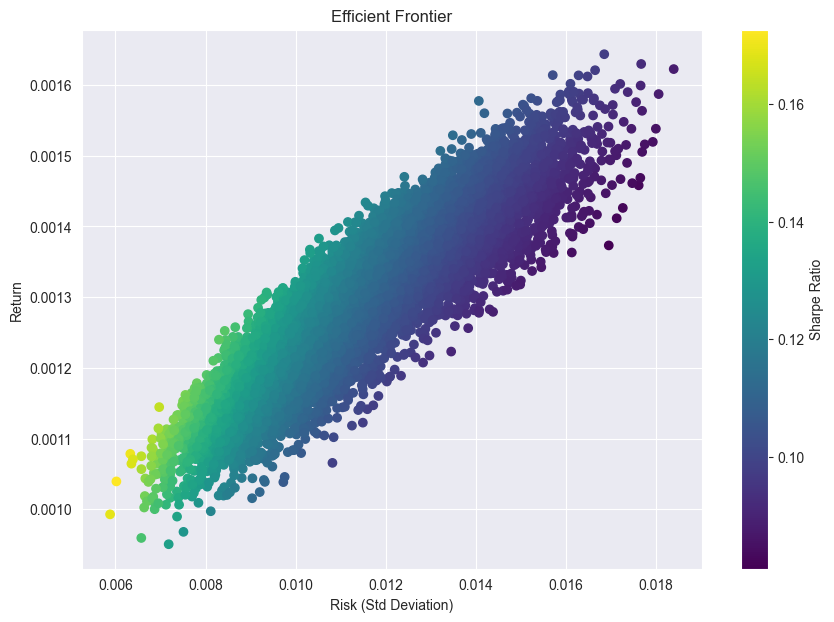

In [16]:
# Step 5: Plot Efficient Frontier
def plot_efficient_frontier(mean_returns, cov_matrix):
    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

# Plot the efficient frontier
plot_efficient_frontier(mean_returns, cov_matrix)

In [18]:
import os
import pandas as pd
import numpy as np

# Define the portfolio for each sector
sectors = {
    "Financial Services": ["AXISBANK", "BAJFINANCE", "HDFCBANK", "HDFCLIFE", "ICICIBANK", "INDUSINDBANK", "KOTAKBANK", "SHRIRAMFIN", "SBIN", "SBILIFE", "BAJFINSV"],
    "Information Technology": ["INFY", "TCS", "WIPRO", "TECHM", "HCLTECH", "LTIM"],
    "Automobile and Auto Components": ["TATAMOTORS", "BAJAJ-AUTO", "EICHERMOT", "M&M", "HEROMOTOCO", "MARUTI"],
    "FMCG": ["ITC", "BRITANIA", "HINDUNILVR", "NESTLEIND", "TATACONSUM"],
    "Healthcare": ["APOLLOHOSP", "CIPLA", "DIVISLAB", "DRREDDY", "SUNPHARMA"],
    "Oil Gas & Consumable Fuels": ["BPCL", "COALINDIA", "ONGC", "RELIANCE"],
    "Metals and Mining": ["ADANIENT", "HINDALCO", "JSWSTEEL", "TATASTEEL"],
    "Construction": ["ULTRATECHCEMCO", "GRASIM", "LT"],
    "Power": ["NTPC", "POWERGRID"],
    "Consumer Durables": ["TITAN", "ASIANPAINT"],
    "Services": ["ADANIPORTS"],
    "Telecommunication": ["BHARATIARTL"]
}

# Function to load stock data for each stock
def load_stock_data(stock):
    file_path = f'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017/{stock}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Data for {stock} not found!")
        return None

# Function to calculate sector-wise portfolio risk
def calculate_sector_risk(sector_stocks):
    sector_data = []
    
    for stock in sector_stocks:
        df = load_stock_data(stock)
        if df is not None:
            df['Returns'] = df['Close'].pct_change()  # Assuming 'Close' price is used for returns
            sector_data.append(df['Returns'].dropna())

    if sector_data:
        sector_returns = pd.concat(sector_data, axis=1)
        sector_cov_matrix = sector_returns.cov()  # Covariance matrix for the sector
        sector_weights = np.ones(len(sector_stocks)) / len(sector_stocks)  # Equal weights
        portfolio_variance = np.dot(sector_weights.T, np.dot(sector_cov_matrix, sector_weights))
        portfolio_risk = np.sqrt(portfolio_variance)
        return portfolio_risk
    else:
        return None

# Calculate and display risk for each sector
sector_risks = {}
for sector, stocks in sectors.items():
    risk = calculate_sector_risk(stocks)
    if risk is not None:
        sector_risks[sector] = risk
        print(f"Portfolio Risk for {sector}: {risk:.4f}")
    else:
        print(f"Could not calculate risk for {sector} due to missing data.")

Data for INDUSINDBANK not found!
Data for SHRIRAMFIN not found!
Data for BAJFINSV not found!


ValueError: shapes (8,8) and (11,) not aligned: 8 (dim 1) != 11 (dim 0)

In [19]:
import os
import pandas as pd
import numpy as np

# Define the portfolio for each sector using NIFTY 50 symbols
sectors = {
    "Financial Services": ["AXISBANK", "BAJFINANCE", "HDFCBANK", "HDFCLIFE", "ICICIBANK", "INDUSINDBANK", "KOTAKBANK", "SHRIRAMFIN", "SBIN", "SBILIFE", "BAJFINSV"],
    "Information Technology": ["INFY", "TCS", "WIPRO", "TECHM", "HCLTECH", "LTIM"],
    "Automobile and Auto Components": ["TATAMOTORS", "BAJAJ-AUTO", "EICHERMOT", "M&M", "HEROMOTOCO", "MARUTI"],
    "FMCG": ["ITC", "BRITANIA", "HINDUNILVR", "NESTLEIND", "TATACONSUM"],
    "Healthcare": ["APOLLOHOSP", "CIPLA", "DIVISLAB", "DRREDDY", "SUNPHARMA"],
    "Oil Gas & Consumable Fuels": ["BPCL", "COALINDIA", "ONGC", "RELIANCE"],
    "Metals and Mining": ["ADANIENT", "HINDALCO", "JSWSTEEL", "TATASTEEL"],
    "Construction": ["ULTRATECHCEMCO", "GRASIM", "LT"],
    "Power": ["NTPC", "POWERGRID"],
    "Consumer Durables": ["TITAN", "ASIANPAINT"],
    "Services": ["ADANIPORTS"],
    "Telecommunication": ["BHARATIARTL"]
}

# Function to load stock data for each stock
def load_stock_data(stock):
    file_path = f'path_to_csv_files/{stock}.csv'  # Update with actual path to CSV files
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Data for {stock} not found!")
        return None

# Function to calculate sector-wise portfolio risk
def calculate_sector_risk(sector_stocks):
    sector_data = []
    
    for stock in sector_stocks:
        df = load_stock_data(stock)
        if df is not None:
            df['Returns'] = df['Close'].pct_change()  # Assuming 'Close' price is used for returns
            sector_data.append(df['Returns'].dropna())

    if sector_data:
        sector_returns = pd.concat(sector_data, axis=1)
        sector_cov_matrix = sector_returns.cov()  # Covariance matrix for the sector
        sector_weights = np.ones(len(sector_stocks)) / len(sector_stocks)  # Equal weights
        portfolio_variance = np.dot(sector_weights.T, np.dot(sector_cov_matrix, sector_weights))
        portfolio_risk = np.sqrt(portfolio_variance)
        return portfolio_risk
    else:
        return None

# Calculate and display risk for each sector
sector_risks = {}
for sector, stocks in sectors.items():
    risk = calculate_sector_risk(stocks)
    if risk is not None:
        sector_risks[sector] = risk
        print(f"Portfolio Risk for {sector}: {risk:.4f}")
    else:
        print(f"Could not calculate risk for {sector} due to missing data.")


Data for AXISBANK not found!
Data for BAJFINANCE not found!
Data for HDFCBANK not found!
Data for HDFCLIFE not found!
Data for ICICIBANK not found!
Data for INDUSINDBANK not found!
Data for KOTAKBANK not found!
Data for SHRIRAMFIN not found!
Data for SBIN not found!
Data for SBILIFE not found!
Data for BAJFINSV not found!
Could not calculate risk for Financial Services due to missing data.
Data for INFY not found!
Data for TCS not found!
Data for WIPRO not found!
Data for TECHM not found!
Data for HCLTECH not found!
Data for LTIM not found!
Could not calculate risk for Information Technology due to missing data.
Data for TATAMOTORS not found!
Data for BAJAJ-AUTO not found!
Data for EICHERMOT not found!
Data for M&M not found!
Data for HEROMOTOCO not found!
Data for MARUTI not found!
Could not calculate risk for Automobile and Auto Components due to missing data.
Data for ITC not found!
Data for BRITANIA not found!
Data for HINDUNILVR not found!
Data for NESTLEIND not found!
Data for TA

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cholesky
from numpy.random import normal
from scipy.optimize import minimize
import os

In [21]:
# Sector-wise NIFTY 50 portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH', 'LTIM'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [22]:
directory = 'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017'


In [23]:
# Step 1: Load NIFTY 50 data from CSVs
stock_data = {}

# Load each CSV file and store in stock_data
for sector, stock_list in sector_portfolios.items():
    for stock in stock_list:
        file_name = f"{stock}.csv"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path):
            stock_data[stock] = pd.read_csv(file_path)
        else:
            print(f"File for {stock} not found.")

File for LTIM not found.


In [24]:
# Combine closing prices for all stocks
close_prices = pd.DataFrame()
for stock, df in stock_data.items():
    close_prices[stock] = df['Close']


In [25]:
# Step 2: Calculate daily returns
returns = close_prices.pct_change().dropna()

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1054269990.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


In [26]:
# Step 3: Portfolio Optimization - Markowitz Efficient Frontier
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights should be 1
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Minimize the variance (risk) given a set return
    def minimize_variance(weights):
        return portfolio_variance(weights, cov_matrix)

    result = minimize(minimize_variance, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [27]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [28]:
# Optimizing the portfolio
optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

# Get the optimal weights, returns, and risk (variance)
optimal_weights = optimal_portfolio['x']
optimal_return = portfolio_return(optimal_weights, mean_returns)
optimal_variance = portfolio_variance(optimal_weights, cov_matrix)

In [29]:
print(f"Optimal Portfolio Weights: {optimal_weights}")
print(f"Optimal Portfolio Return: {optimal_return}")
print(f"Optimal Portfolio Variance: {optimal_variance}")

Optimal Portfolio Weights: [2.18666931e-02 1.19262239e-18 2.27986191e-02 2.47050362e-02
 2.30421165e-02 2.35136880e-02 1.76311953e-02 2.38681675e-02
 2.29819386e-02 2.47794307e-02 2.22788950e-02 2.33262773e-02
 2.17509790e-02 2.45027653e-02 2.43501729e-02 2.14041673e-02
 2.43208448e-02 6.50521303e-19 2.30963623e-02 2.38890263e-02
 2.45806379e-02 2.32939607e-02 2.37500751e-02 2.31834503e-02
 2.48134721e-02 2.26273986e-02 2.38333304e-02 4.04936118e-04
 2.43916832e-02 2.29321046e-02 2.30096144e-02 9.79444670e-03
 2.47949019e-02 2.12490465e-02 1.95847430e-02 2.34620847e-02
 2.17879575e-02 2.36157035e-02 2.85655477e-03 2.43235238e-02
 1.03428734e-02 2.40864863e-02 2.47489080e-02 2.47253586e-02
 2.18478682e-02 2.41045432e-02 2.42395633e-02 2.35083978e-02]
Optimal Portfolio Return: 0.000878069683728878
Optimal Portfolio Variance: 2.6667159676104476e-05


In [30]:
def monte_carlo_var(portfolio_weights, returns, cov_matrix, num_simulations=1000, confidence_level=0.95):
    num_assets = len(returns.columns)
    portfolio_mean = np.dot(portfolio_weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
    
    # Simulate portfolio returns
    simulated_returns = np.random.normal(portfolio_mean, portfolio_stddev, num_simulations)
    
    # Calculate VaR at the given confidence level
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value

In [31]:
# Running Monte Carlo Simulation for VaR
confidence_level = 0.95
var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")


Value at Risk (VaR) at 95.0% confidence level: -0.0076524853792841055


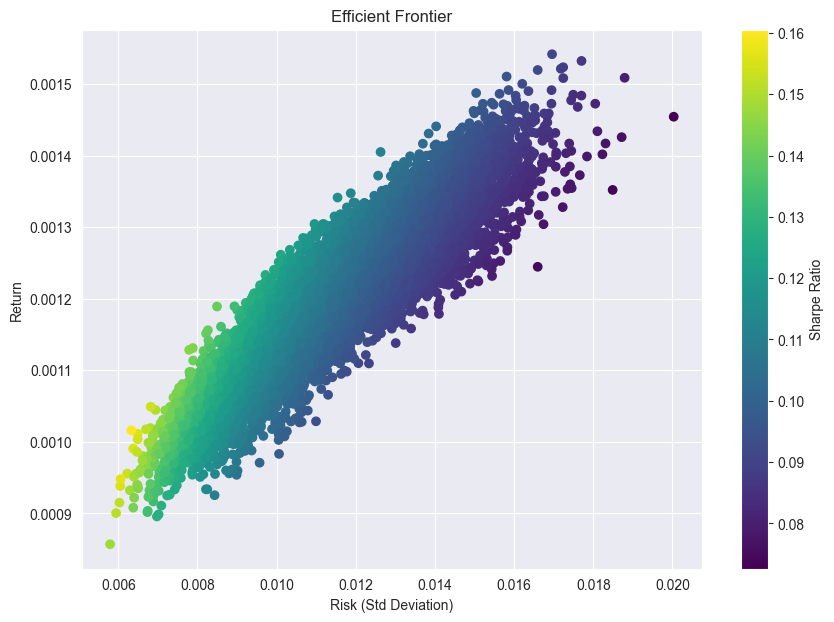

In [32]:
# Step 5: Plot Efficient Frontier
def plot_efficient_frontier(mean_returns, cov_matrix):
    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

# Plot the efficient frontier
plot_efficient_frontier(mean_returns, cov_matrix)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

In [34]:
# Sector-wise NIFTY 50 portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH', 'LTIM'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [35]:
directory = 'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017'


In [36]:
# Define functions for portfolio optimization and risk assessment
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def minimize_variance(weights):
        return portfolio_variance(weights, cov_matrix)

    result = minimize(minimize_variance, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def monte_carlo_var(portfolio_weights, returns, cov_matrix, num_simulations=1000, confidence_level=0.95):
    num_assets = len(returns.columns)
    portfolio_mean = np.dot(portfolio_weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
    
    simulated_returns = np.random.normal(portfolio_mean, portfolio_stddev, num_simulations)
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value


In [37]:
# Perform analysis for each sector as a single portfolio
for sector, stocks in sector_portfolios.items():
    # Load and combine stock data for the sector
    sector_data = {}
    for stock in stocks:
        file_name = f"{stock}.csv"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path):
            sector_data[stock] = pd.read_csv(file_path)
        else:
            print(f"File for {stock} not found in sector {sector}.")

    # Combine closing prices for the sector
    close_prices = pd.DataFrame()
    for stock, df in sector_data.items():
        close_prices[stock] = df['Close']

    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    
    # Compute mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Optimize the portfolio
    optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

    # Get the optimal weights, returns, and risk (variance)
    optimal_weights = optimal_portfolio['x']
    optimal_return = portfolio_return(optimal_weights, mean_returns)
    optimal_variance = portfolio_variance(optimal_weights, cov_matrix)
    confidence_level = 0.95
    var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

    print(f"\nSector: {sector}")
    print(f"Optimal Portfolio Weights: {optimal_weights}")
    print(f"Optimal Portfolio Return: {optimal_return}")
    print(f"Optimal Portfolio Variance: {optimal_variance}")
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_


Sector: Financial Services
Optimal Portfolio Weights: [0.11328122 0.         0.11702515 0.11868117 0.11313169 0.1134874
 0.07527387 0.11446984 0.11495845 0.11969121]
Optimal Portfolio Return: 0.0008906596147417548
Optimal Portfolio Variance: 8.638254913236145e-05
Value at Risk (VaR) at 95.0% confidence level: -0.01506106397929223
File for LTIM not found in sector Information Technology.

Sector: Information Technology
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0008051141195073486
Optimal Portfolio Variance: 0.00016401124976872782
Value at Risk (VaR) at 95.0% confidence level: -0.02055693896434828

Sector: Automobile and Auto Components
Optimal Portfolio Weights: [0.19280455 0.20141786 0.00855313 0.19469279 0.2016422  0.20088947]
Optimal Portfolio Return: 0.0008867110022980191
Optimal Portfolio Variance: 0.00010598861609140816
Value at Risk (VaR) at 95.0% confidence level: -0.015966967691688698


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_


Sector: Fast Moving Consumer Goods
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0006474151650221231
Optimal Portfolio Variance: 8.384585956381233e-05
Value at Risk (VaR) at 95.0% confidence level: -0.01395283850133183

Sector: Healthcare
Optimal Portfolio Weights: [0.24998655 0.00150242 0.24999255 0.24892003 0.24959844]
Optimal Portfolio Return: 0.0010783002675130667
Optimal Portfolio Variance: 0.0001411227421065707
Value at Risk (VaR) at 95.0% confidence level: -0.01762919734258752

Sector: Oil Gas & Consumable Fuels
Optimal Portfolio Weights: [0.         0.40519786 0.31816768 0.27663446]
Optimal Portfolio Return: 0.0005872763037934078
Optimal Portfolio Variance: 0.00020340357266136253
Value at Risk (VaR) at 95.0% confidence level: -0.02199687782920842

Sector: Metals and Mining
Optimal Portfolio Weights: [0.32860148 0.33068522 0.33507054 0.00564276]
Optimal Portfolio Return: 0.0013311983883133077
Optimal Portfolio Variance: 0.00030828572543761975
Valu

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Financial Services
Optimal Portfolio Weights: [0.11328122 0.         0.11702515 0.11868117 0.11313169 0.1134874
 0.07527387 0.11446984 0.11495845 0.11969121]
Optimal Portfolio Return: 0.0008906596147417548
Optimal Portfolio Variance: 8.638254913236145e-05
Value at Risk (VaR) at 95.0% confidence level: -0.014559548624245003


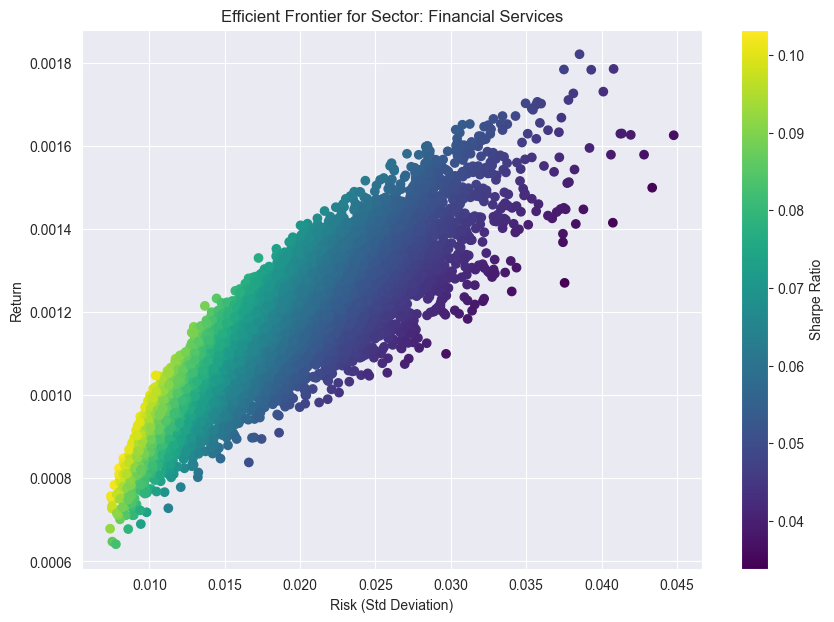

File for LTIM not found in sector Information Technology.

Sector: Information Technology
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0008051141195073486
Optimal Portfolio Variance: 0.00016401124976872782
Value at Risk (VaR) at 95.0% confidence level: -0.021558918186660725


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


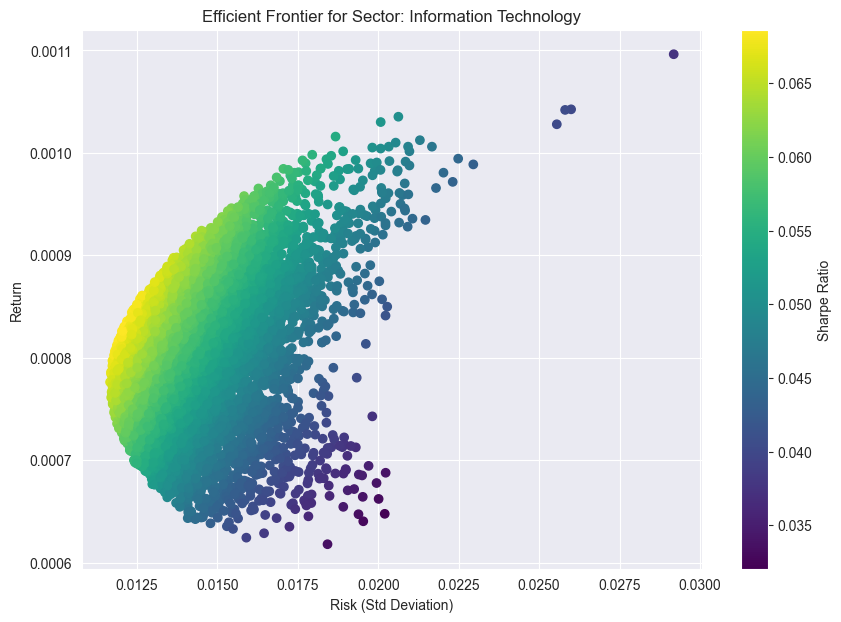

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Automobile and Auto Components
Optimal Portfolio Weights: [0.19280455 0.20141786 0.00855313 0.19469279 0.2016422  0.20088947]
Optimal Portfolio Return: 0.0008867110022980191
Optimal Portfolio Variance: 0.00010598861609140816
Value at Risk (VaR) at 95.0% confidence level: -0.0163160236901823


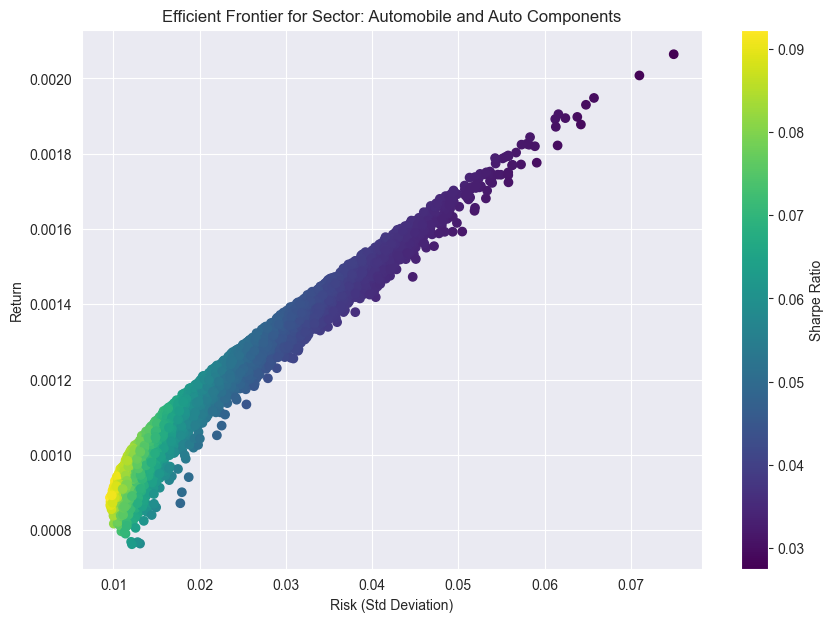

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Fast Moving Consumer Goods
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0006474151650221231
Optimal Portfolio Variance: 8.384585956381233e-05
Value at Risk (VaR) at 95.0% confidence level: -0.014696468637212787


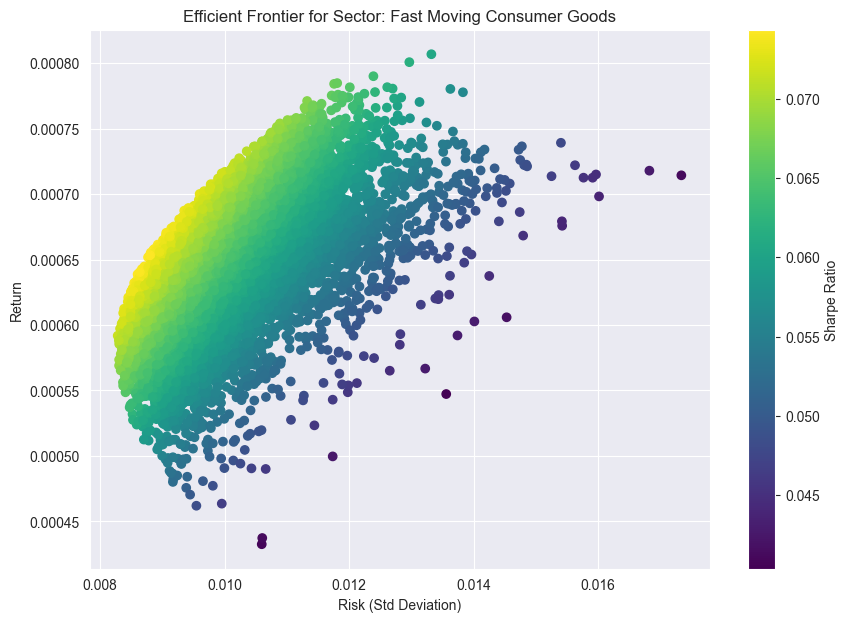

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Healthcare
Optimal Portfolio Weights: [0.24998655 0.00150242 0.24999255 0.24892003 0.24959844]
Optimal Portfolio Return: 0.0010783002675130667
Optimal Portfolio Variance: 0.0001411227421065707
Value at Risk (VaR) at 95.0% confidence level: -0.01833801732214915


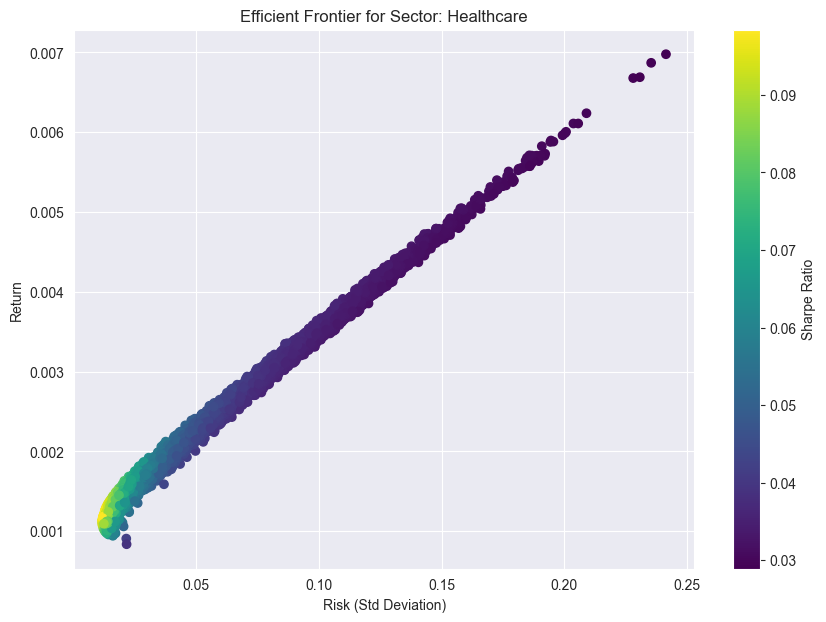

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Oil Gas & Consumable Fuels
Optimal Portfolio Weights: [0.         0.40519786 0.31816768 0.27663446]
Optimal Portfolio Return: 0.0005872763037934078
Optimal Portfolio Variance: 0.00020340357266136253
Value at Risk (VaR) at 95.0% confidence level: -0.020990717019182575


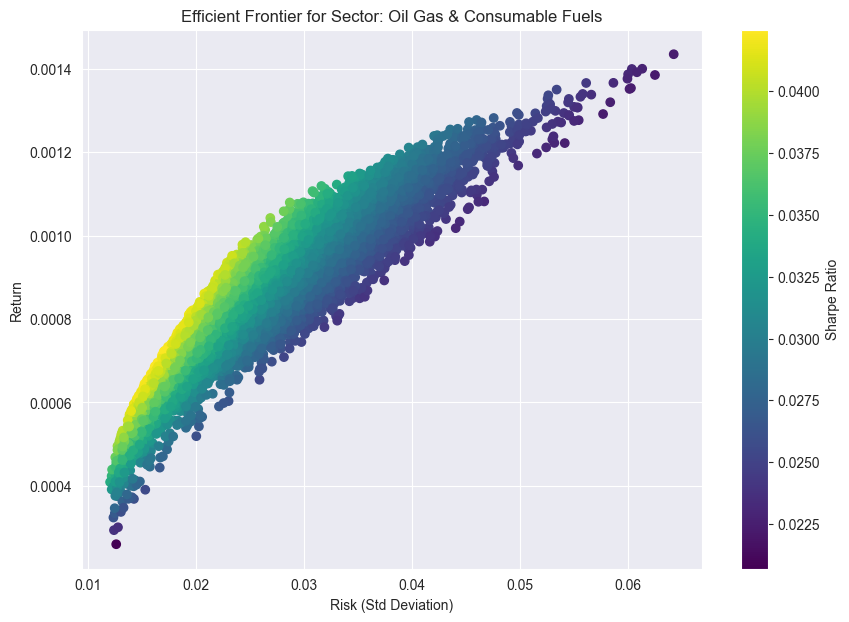

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Metals and Mining
Optimal Portfolio Weights: [0.32860148 0.33068522 0.33507054 0.00564276]
Optimal Portfolio Return: 0.0013311983883133077
Optimal Portfolio Variance: 0.00030828572543761975
Value at Risk (VaR) at 95.0% confidence level: -0.026359282455423926


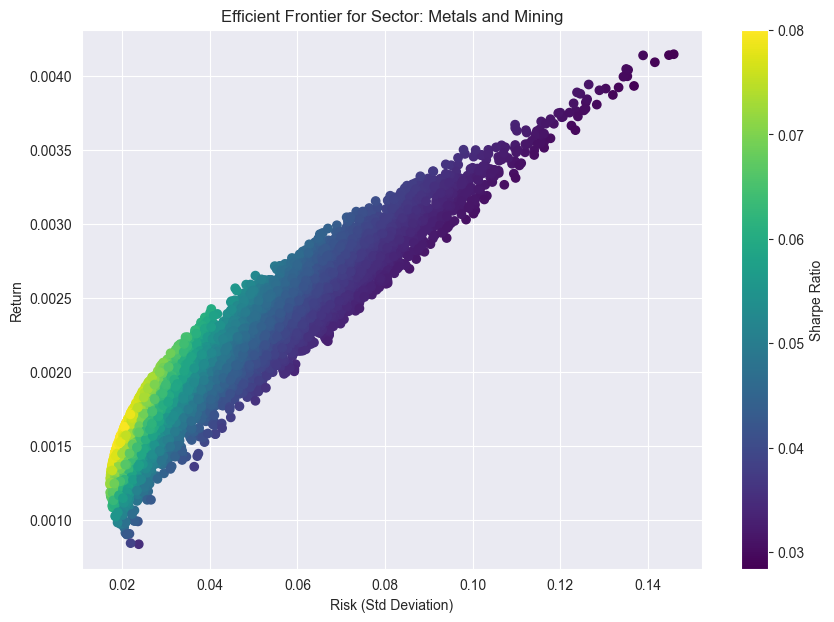


Sector: Construction
Optimal Portfolio Weights: [0.48452445 0.04760192 0.46787363]
Optimal Portfolio Return: 0.0011058388958042772
Optimal Portfolio Variance: 0.0002858029112634259
Value at Risk (VaR) at 95.0% confidence level: -0.02585131283954951


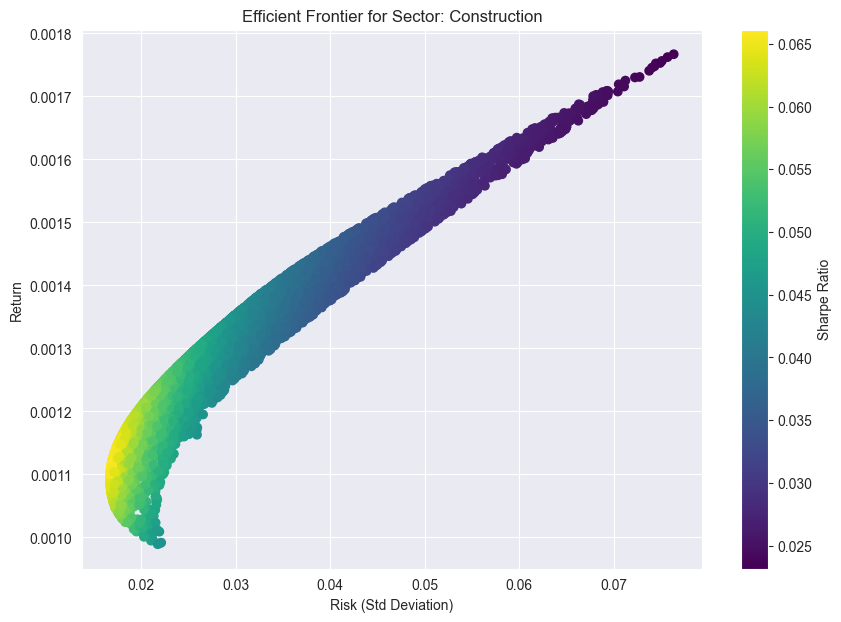

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Power
Optimal Portfolio Weights: [0.5 0.5]
Optimal Portfolio Return: 0.0005348449189742846
Optimal Portfolio Variance: 0.00015557908942749187
Value at Risk (VaR) at 95.0% confidence level: -0.01826514132021794


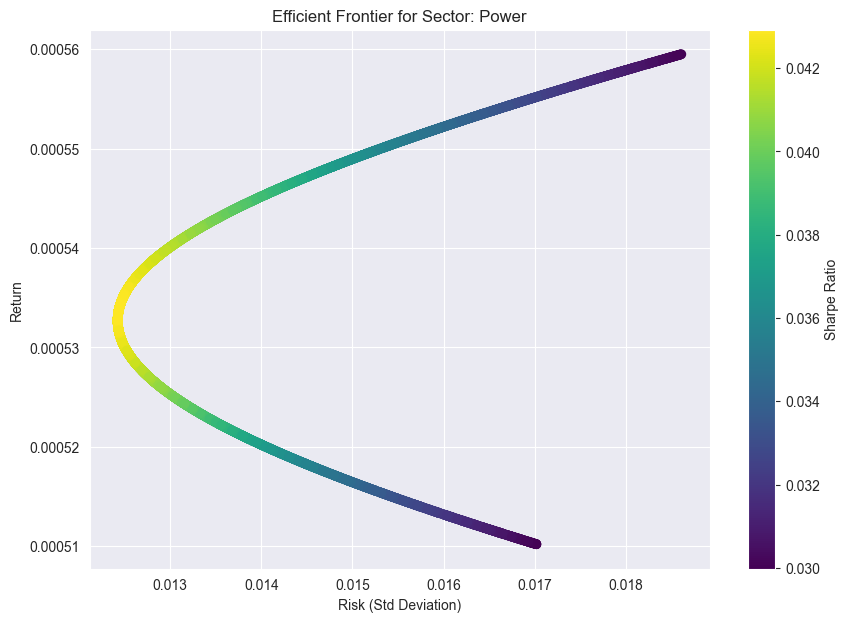

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Consumer Durables
Optimal Portfolio Weights: [0.5 0.5]
Optimal Portfolio Return: 0.0011448759350786658
Optimal Portfolio Variance: 0.00025105720950725145
Value at Risk (VaR) at 95.0% confidence level: -0.02442476991804146


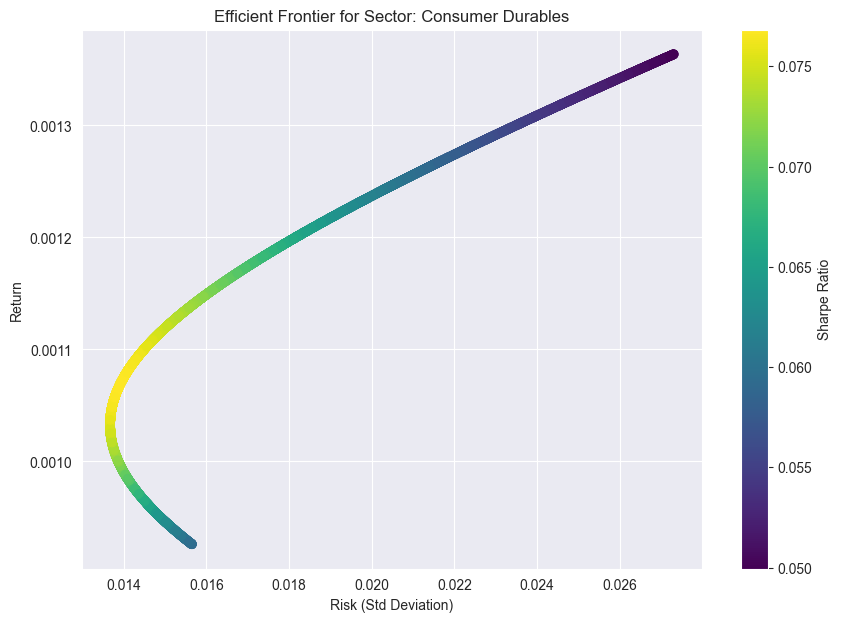


Sector: Services
Optimal Portfolio Weights: [1.]
Optimal Portfolio Return: 0.0008523566598222411
Optimal Portfolio Variance: 0.0007131430512318371
Value at Risk (VaR) at 95.0% confidence level: -0.04403922130068767


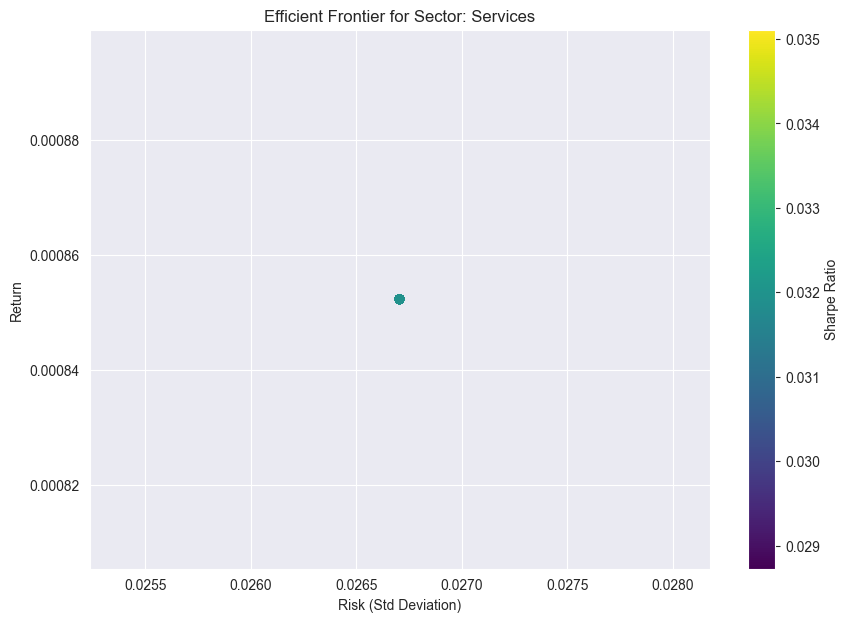


Sector: Telecommunication
Optimal Portfolio Weights: [1.]
Optimal Portfolio Return: 0.0011016250994222575
Optimal Portfolio Variance: 0.0005287492869783724
Value at Risk (VaR) at 95.0% confidence level: -0.035557792538987464


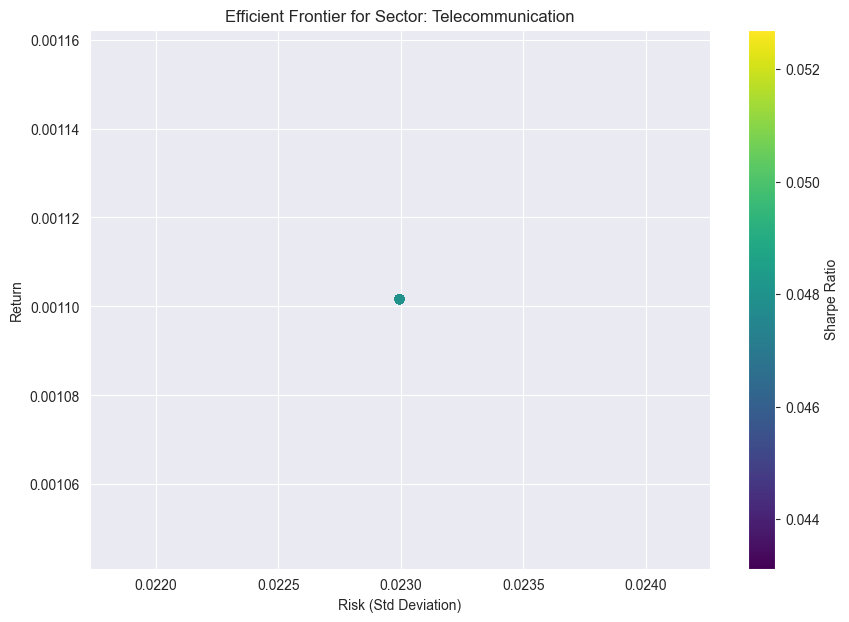

In [39]:
# Perform analysis for each sector as a single portfolio
for sector, stocks in sector_portfolios.items():
    # Load and combine stock data for the sector
    sector_data = {}
    for stock in stocks:
        file_name = f"{stock}.csv"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path):
            sector_data[stock] = pd.read_csv(file_path)
        else:
            print(f"File for {stock} not found in sector {sector}.")

    # Combine closing prices for the sector
    close_prices = pd.DataFrame()
    for stock, df in sector_data.items():
        close_prices[stock] = df['Close']

    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    
    # Compute mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Optimize the portfolio
    optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

    # Get the optimal weights, returns, and risk (variance)
    optimal_weights = optimal_portfolio['x']
    optimal_return = portfolio_return(optimal_weights, mean_returns)
    optimal_variance = portfolio_variance(optimal_weights, cov_matrix)
    confidence_level = 0.95
    var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

    print(f"\nSector: {sector}")
    print(f"Optimal Portfolio Weights: {optimal_weights}")
    print(f"Optimal Portfolio Return: {optimal_return}")
    print(f"Optimal Portfolio Variance: {optimal_variance}")
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")

    # Plot efficient frontier for the sector (optional)
    def plot_efficient_frontier(mean_returns, cov_matrix, sector_name):
        num_portfolios = 10000
        results = np.zeros((3, num_portfolios))
        for i in range(num_portfolios):
            weights = np.random.random(len(mean_returns))
            weights /= np.sum(weights)
            
            portfolio_return = np.dot(weights, mean_returns)
            portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            
            results[0,i] = portfolio_return
            results[1,i] = portfolio_stddev
            results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

        plt.figure(figsize=(10, 7))
        plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
        plt.title(f'Efficient Frontier for Sector: {sector_name}')
        plt.xlabel('Risk (Std Deviation)')
        plt.ylabel('Return')
        plt.colorbar(label='Sharpe Ratio')
        plt.show()

    plot_efficient_frontier(mean_returns, cov_matrix, sector)

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [24]:
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [25]:
# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

In [26]:
# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

In [27]:
# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

In [28]:
# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value

In [29]:
# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

In [30]:
# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns


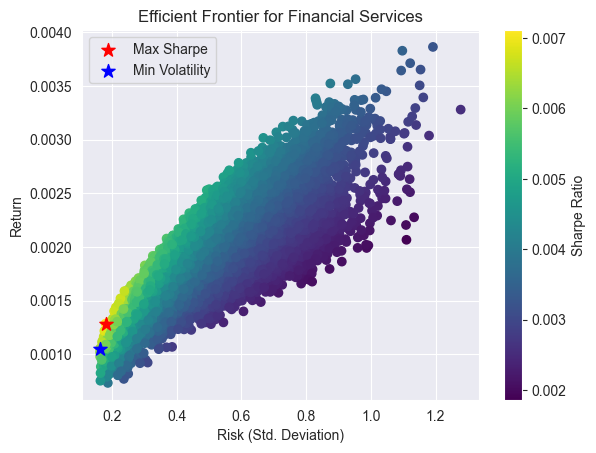

Sector: Financial Services
Value at Risk (VaR) at 95% confidence level: 0.24745308655822826


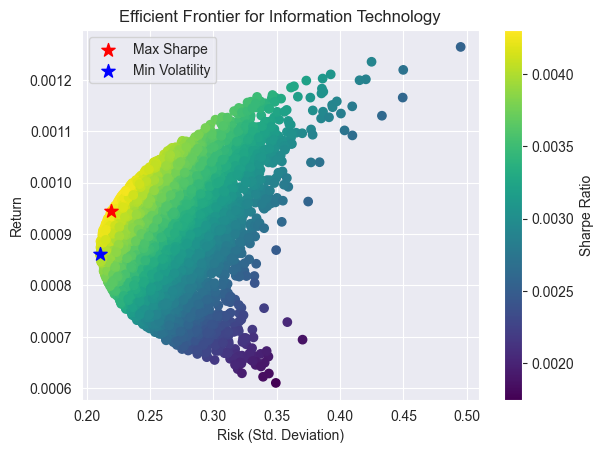

Sector: Information Technology
Value at Risk (VaR) at 95% confidence level: 0.21884118104457292


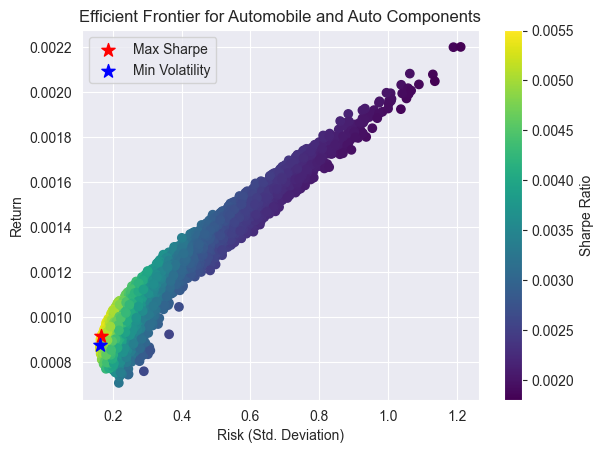

Sector: Automobile and Auto Components
Value at Risk (VaR) at 95% confidence level: 0.18925890105333099


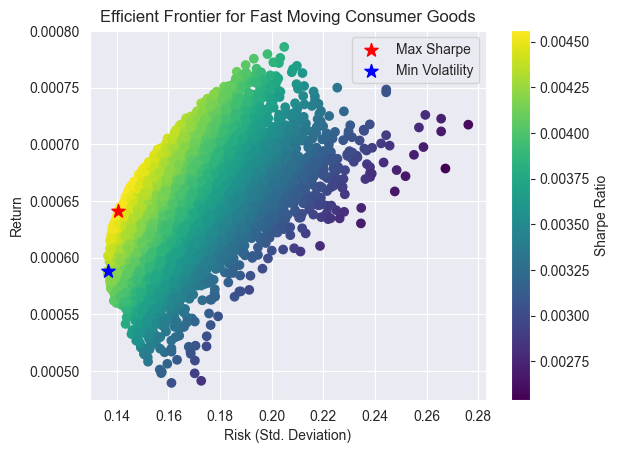

Sector: Fast Moving Consumer Goods
Value at Risk (VaR) at 95% confidence level: 0.14326893579781252


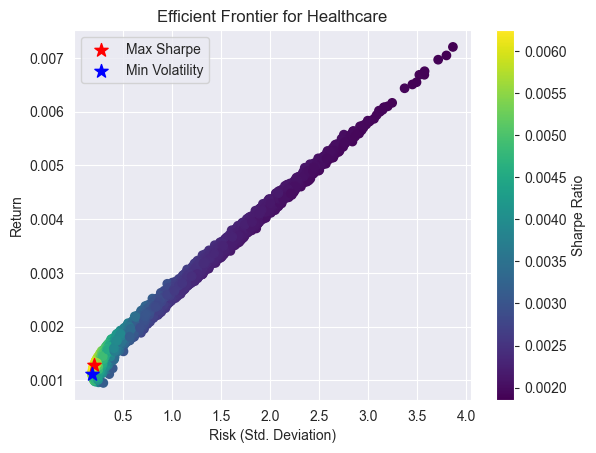

Sector: Healthcare
Value at Risk (VaR) at 95% confidence level: 0.25277560141872574


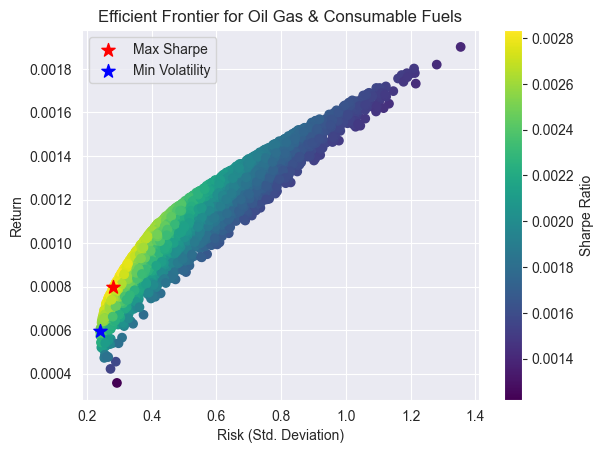

Sector: Oil Gas & Consumable Fuels
Value at Risk (VaR) at 95% confidence level: 0.3065098259131067


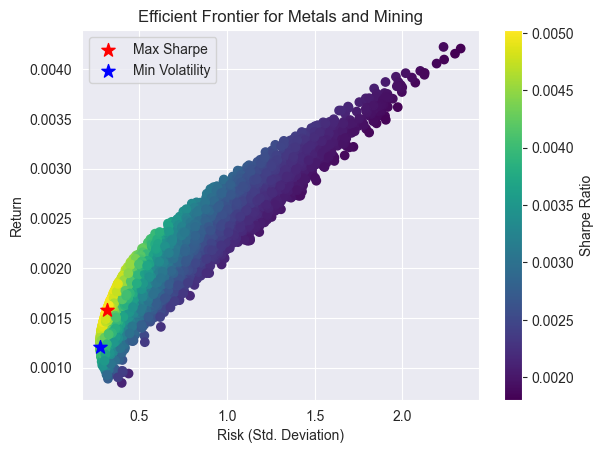

Sector: Metals and Mining
Value at Risk (VaR) at 95% confidence level: 0.31727226135738384


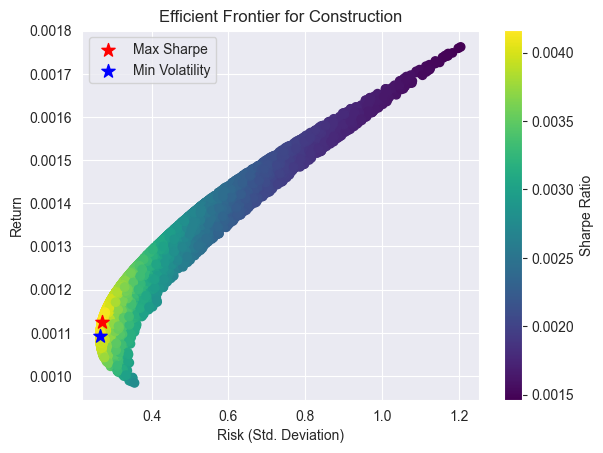

Sector: Construction
Value at Risk (VaR) at 95% confidence level: 0.27577040626188826


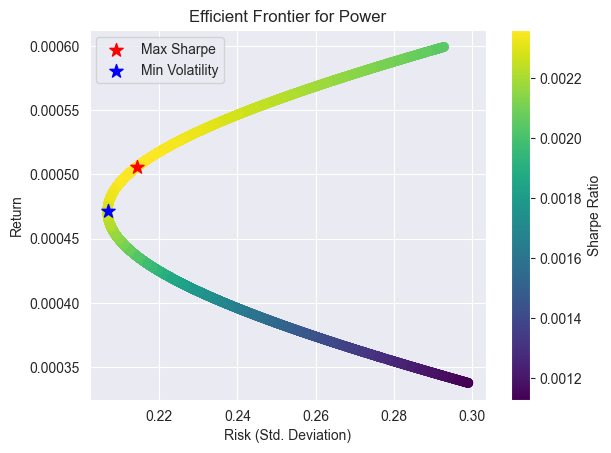

Sector: Power
Value at Risk (VaR) at 95% confidence level: 0.20690742413980628


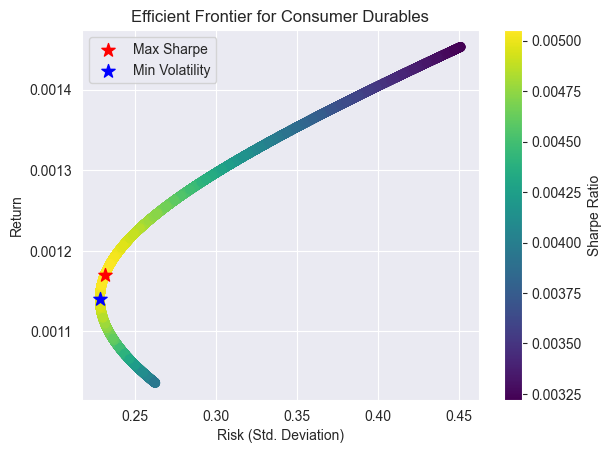

Sector: Consumer Durables
Value at Risk (VaR) at 95% confidence level: 0.2289980987957075


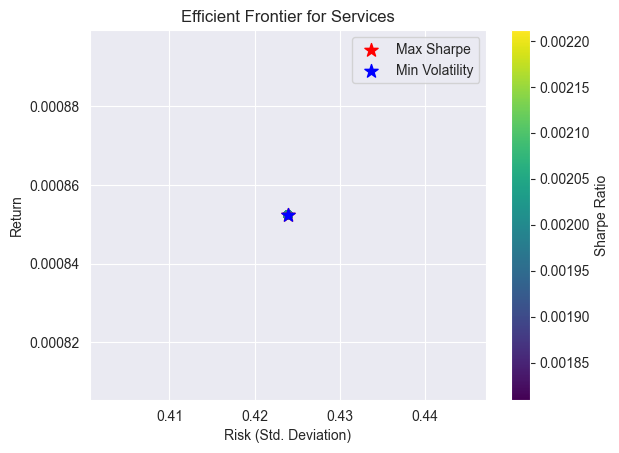

Sector: Services
Value at Risk (VaR) at 95% confidence level: 0.42392457927138755


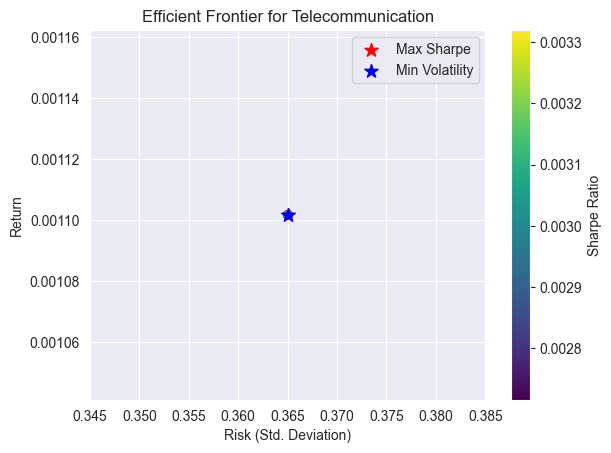

Sector: Telecommunication
Value at Risk (VaR) at 95% confidence level: 0.365027150111536


In [31]:
# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    print(f"Sector: {sector_name}")
    print(f"Value at Risk (VaR) at 95% confidence level: {var_value}")
    print("="*50)

# Loop to calculate for each sector
for sector, stocks in sector_portfolios.items():
    calculate_efficient_frontier_and_var(sector, stocks, data_directory)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    print(f"Sector: {sector_name}")
    print(f"Value at Risk (VaR) at 95% confidence level: {var_value}")
    print("="*50)
    
    # Return VaR and risk for table
    min_volatility_risk = results[1, min_volatility_idx]
    return var_value, min_volatility_risk

# Initialize lists to store results
var_results = []
risk_results = []

# Loop to calculate for each sector
for sector, stocks in sector_portfolios.items():
    var_value, risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None and risk is not None:
        var_results.append(var_value)
        risk_results.append(risk)

# Create a DataFrame to display results
results_df = pd.DataFrame({
    'Sector': list(sector_portfolios.keys()),
    'Value at Risk (VaR)': var_results,
    'Risk (Std. Deviation)': risk_results
})

print("\nSector-wise VaR and Risk:")
print(results_df)


TypeError: monte_carlo_var() missing 1 required positional argument: 'weights'

In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [34]:
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [35]:
# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

In [42]:
# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, weights, num_simulations=10000, confidence_level=0.95):
    num_stocks = stock_returns.shape[1]
    portfolio_risks = []
    
    for _ in range(num_simulations):
        portfolio_return = np.sum(stock_returns.mean() * weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(stock_returns.cov() * 252, weights)))
        portfolio_risks.append(portfolio_risk)
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))  # Return, Risk, Sharpe Ratio
    weights_record = []
    
    # Generate random portfolios
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_risk
        results[2, i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate VaR and Risk for each sector separately
def calculate_var_and_risk_for_sector(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Efficient Frontier Calculation
    num_portfolios = 10  # Number of portfolios for which we calculate VaR and risk
    results, weights_record = optimize_portfolio(mean_returns, cov_matrix, num_portfolios=num_portfolios)
    
    sector_var = []
    sector_risk = []
    
    print(f"\nVaR and Risk for {sector_name} Sector")
    print(f"{'Portfolio':<12}{'VaR(TL)':<12}{'Risk(σ)':<12}")
    
    # Loop through the portfolios and calculate VaR and Risk for each portfolio
    for i in range(num_portfolios):
        weights = weights_record[i]
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        var_value = monte_carlo_var(stock_returns, weights)
        
        sector_var.append(var_value)
        sector_risk.append(portfolio_risk)
        
        print(f"Portfolio-{i+1:<4} {var_value:<12.4f} {portfolio_risk:<12.4f}")
    
    return sector_var, sector_risk

# Loop to calculate VaR and Risk for each sector separately
sector_results = {}

In [44]:
for sector, stocks in sector_portfolios.items():
    var, risk = calculate_var_and_risk_for_sector(sector, stocks, data_directory)
    sector_results[sector] = {
        'VaR': var,
        'Risk': risk
    }

# Optional: Print final sector-wise results
print("\nSummary of VaR and Risk for each Sector:")
for sector, data in sector_results.items():
    print(f"\n{sector} Sector:")
    for i in range(len(data['VaR'])):
        print(f"Portfolio-{i+1}: VaR = {data['VaR'][i]:.4f}, Risk = {data['Risk'][i]:.4f}")


VaR and Risk for Financial Services Sector
Portfolio   VaR(TL)     Risk(σ)     
Portfolio-1    0.4889       0.4889      
Portfolio-2    0.3633       0.3633      
Portfolio-3    0.4210       0.4210      
Portfolio-4    0.3061       0.3061      
Portfolio-5    0.5024       0.5024      
Portfolio-6    0.3576       0.3576      
Portfolio-7    0.6881       0.6881      
Portfolio-8    0.5270       0.5270      
Portfolio-9    0.6682       0.6682      
Portfolio-10   1.0245       1.0245      

VaR and Risk for Information Technology Sector
Portfolio   VaR(TL)     Risk(σ)     
Portfolio-1    0.2366       0.2366      
Portfolio-2    0.2449       0.2449      
Portfolio-3    0.2534       0.2534      
Portfolio-4    0.2517       0.2517      
Portfolio-5    0.2427       0.2427      
Portfolio-6    0.2336       0.2336      
Portfolio-7    0.2707       0.2707      
Portfolio-8    0.2287       0.2287      
Portfolio-9    0.2838       0.2838      
Portfolio-10   0.2822       0.2822      

VaR and Risk 

In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load sector-wise portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, weights, num_simulations=10000, confidence_level=0.95):
    num_stocks = stock_returns.shape[1]
    portfolio_risks = []
    
    for _ in range(num_simulations):
        portfolio_return = np.sum(stock_returns.mean() * weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(stock_returns.cov() * 252, weights)))
        portfolio_risks.append(portfolio_risk)
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate VaR and Risk for a sector as one portfolio
def calculate_var_and_risk_for_sector(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Assume equal weights for simplicity, or you can use optimized weights
    num_assets = len(stock_list)
    weights = np.ones(num_assets) / num_assets  # Equal weights for each stock

    # Calculate portfolio performance
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)

    # Perform Monte Carlo simulation to calculate VaR
    var_value = monte_carlo_var(stock_returns, weights)

    print(f"\nVaR and Risk for {sector_name} Sector")
    print(f"{'Sector':<20}{'VaR(TL)':<12}{'Risk(σ)':<12}")
    print(f"{sector_name:<20} {var_value:<12.4f} {portfolio_risk:<12.4f}")

    return var_value, portfolio_risk

# Loop to calculate VaR and Risk for each sector separately
sector_results = {}

for sector, stocks in sector_portfolios.items():
    var, risk = calculate_var_and_risk_for_sector(sector, stocks, data_directory)
    sector_results[sector] = {
        'VaR': var,
        'Risk': risk
    }

# Optional: Print final sector-wise results
print("\nSummary of VaR and Risk for each Sector:")
for sector, data in sector_results.items():
    print(f"{sector} Sector: VaR = {data['VaR']:.4f}, Risk = {data['Risk']:.4f}")



VaR and Risk for Financial Services Sector
Sector              VaR(TL)     Risk(σ)     
Financial Services   0.4809       0.4809      

VaR and Risk for Information Technology Sector
Sector              VaR(TL)     Risk(σ)     
Information Technology 0.2298       0.2298      

VaR and Risk for Automobile and Auto Components Sector
Sector              VaR(TL)     Risk(σ)     
Automobile and Auto Components 0.3664       0.3664      

VaR and Risk for Fast Moving Consumer Goods Sector
Sector              VaR(TL)     Risk(σ)     
Fast Moving Consumer Goods 0.1500       0.1500      

VaR and Risk for Healthcare Sector
Sector              VaR(TL)     Risk(σ)     
Healthcare           1.0607       1.0607      

VaR and Risk for Oil Gas & Consumable Fuels Sector
Sector              VaR(TL)     Risk(σ)     
Oil Gas & Consumable Fuels 0.5243       0.5243      

VaR and Risk for Metals and Mining Sector
Sector              VaR(TL)     Risk(σ)     
Metals and Mining    0.7134       0.7134      



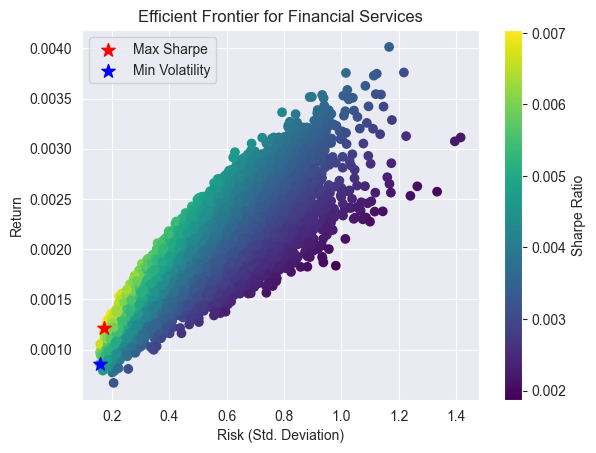

Sector: Financial Services
Value at Risk (VaR) at 95% confidence level: 0.24576603658898616
Mean Portfolio Risk: 0.5243145497280242


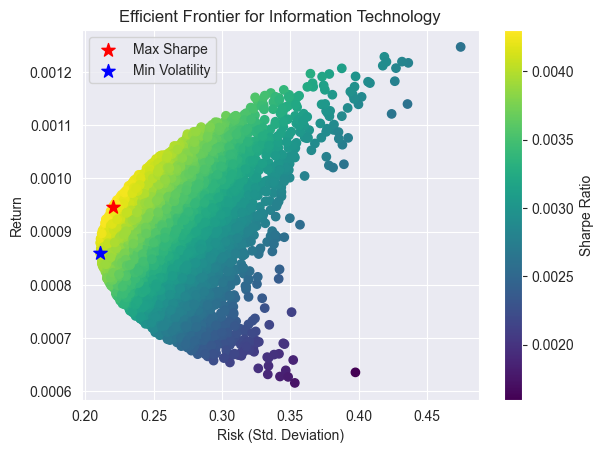

Sector: Information Technology
Value at Risk (VaR) at 95% confidence level: 0.21838995978401793
Mean Portfolio Risk: 0.25417303784295175


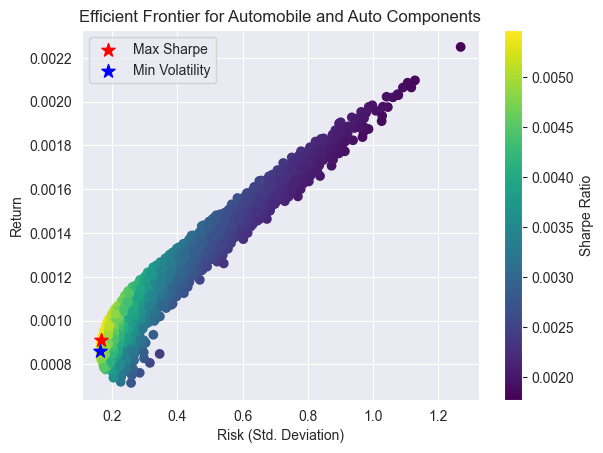

Sector: Automobile and Auto Components
Value at Risk (VaR) at 95% confidence level: 0.18891983461458367
Mean Portfolio Risk: 0.3906701516809447


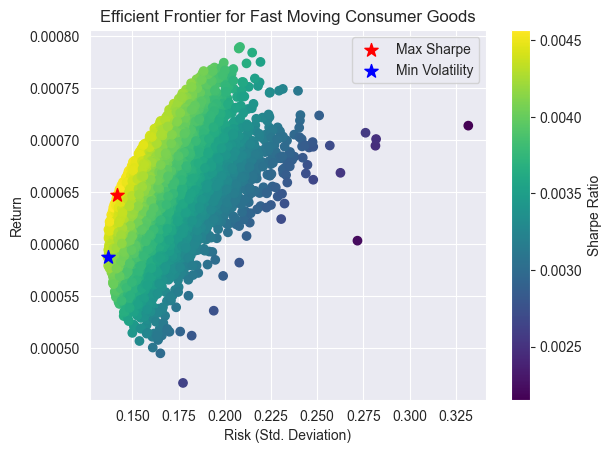

Sector: Fast Moving Consumer Goods
Value at Risk (VaR) at 95% confidence level: 0.14343786810560927
Mean Portfolio Risk: 0.16501711537293098


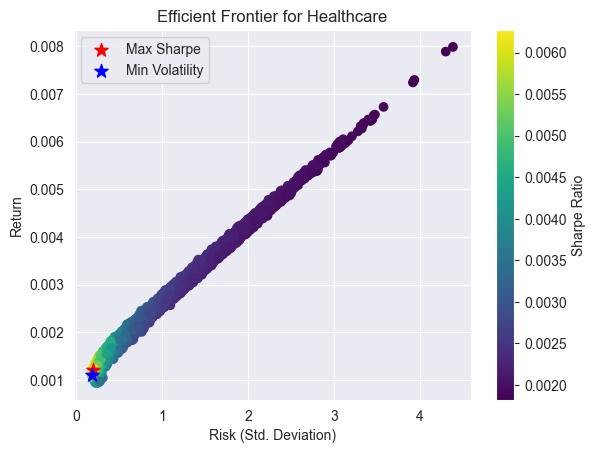

Sector: Healthcare
Value at Risk (VaR) at 95% confidence level: 0.2454379757047077
Mean Portfolio Risk: 1.0785601832551905


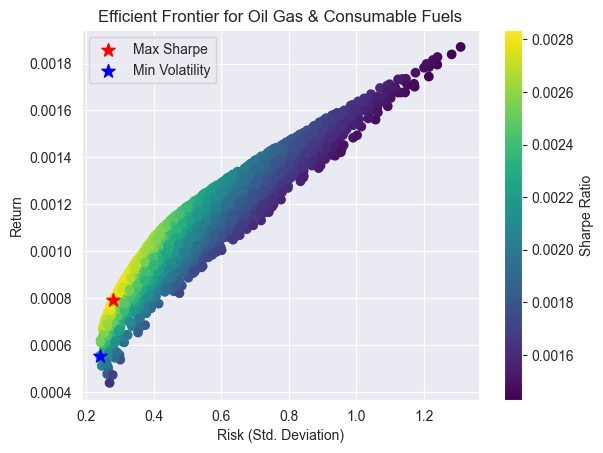

Sector: Oil Gas & Consumable Fuels
Value at Risk (VaR) at 95% confidence level: 0.30690941008370753
Mean Portfolio Risk: 0.537756497111318


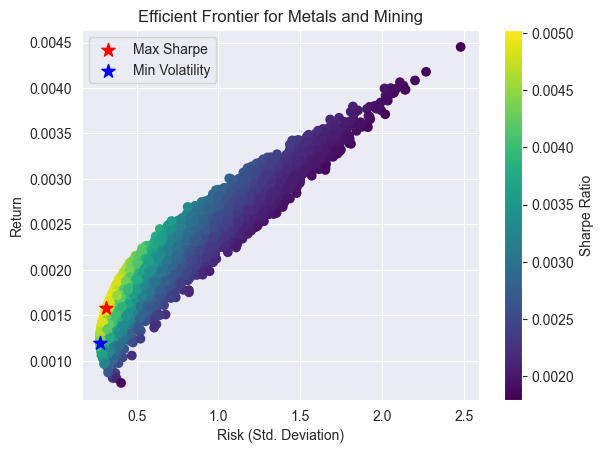

Sector: Metals and Mining
Value at Risk (VaR) at 95% confidence level: 0.31900224162688023
Mean Portfolio Risk: 0.7513611986223311


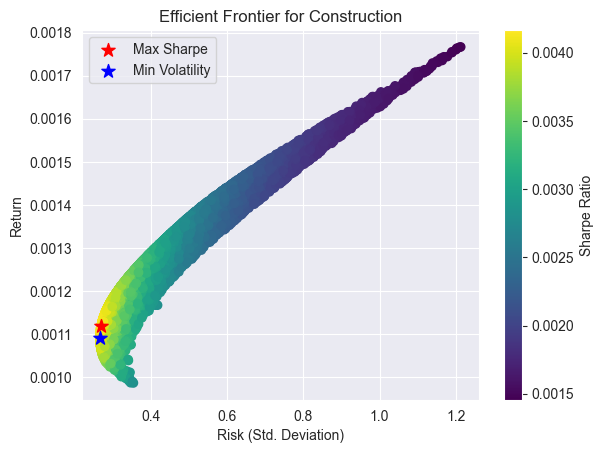

Sector: Construction
Value at Risk (VaR) at 95% confidence level: 0.2759965075579048
Mean Portfolio Risk: 0.48284527305628105


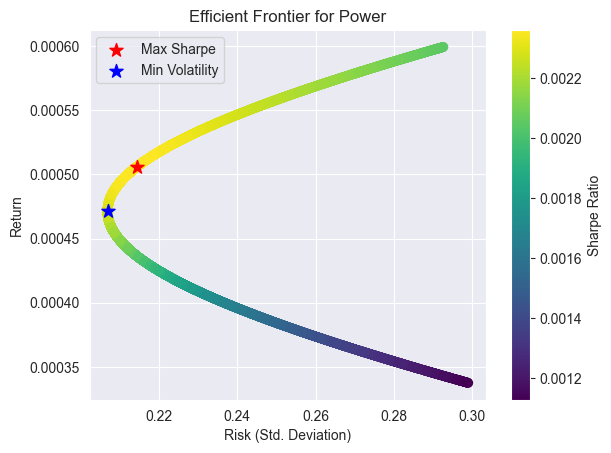

Sector: Power
Value at Risk (VaR) at 95% confidence level: 0.2068974164856128
Mean Portfolio Risk: 0.22894776018965385


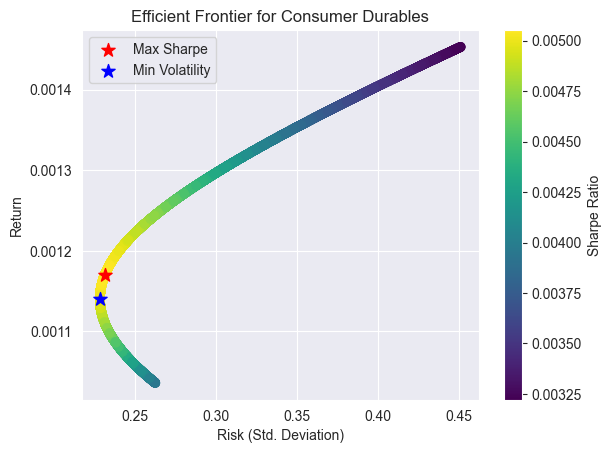

Sector: Consumer Durables
Value at Risk (VaR) at 95% confidence level: 0.22905483057316667
Mean Portfolio Risk: 0.2853775127051886


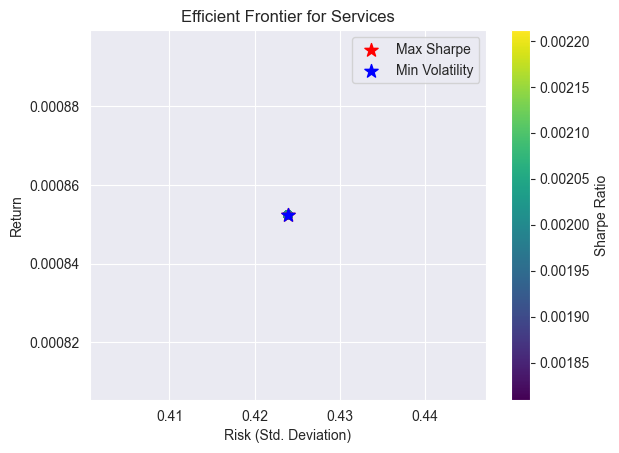

Sector: Services
Value at Risk (VaR) at 95% confidence level: 0.42392457927138755
Mean Portfolio Risk: 0.42392457927138766


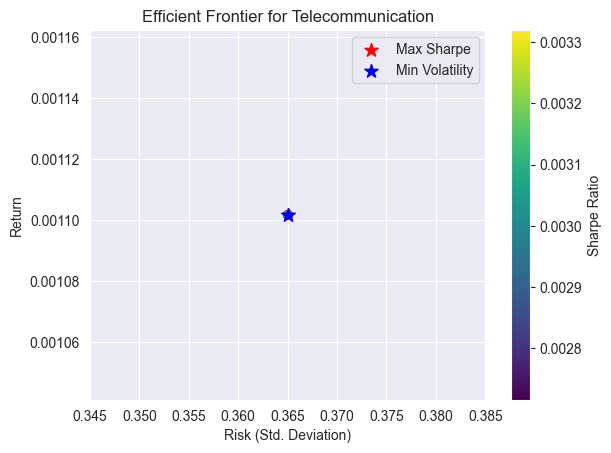

Sector: Telecommunication
Value at Risk (VaR) at 95% confidence level: 0.365027150111536
Mean Portfolio Risk: 0.365027150111536


In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    print(f"Sector: {sector_name}")
    print(f"Value at Risk (VaR) at 95% confidence level: {var_value}")
    print(f"Mean Portfolio Risk: {mean_risk}")
    print("="*50)

# Loop to calculate for each sector
for sector, stocks in sector_portfolios.items():
    calculate_efficient_frontier_and_var(sector, stocks, data_directory)


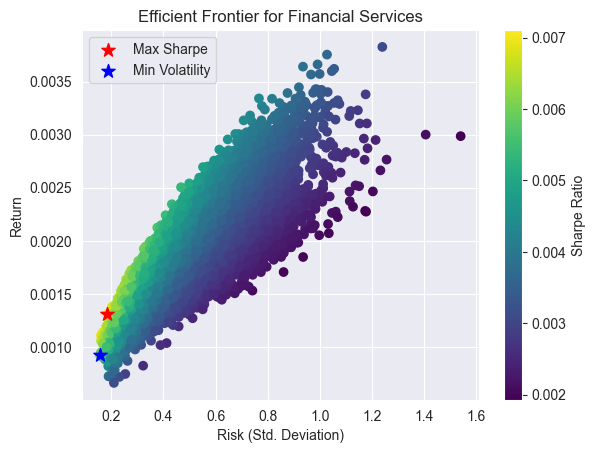

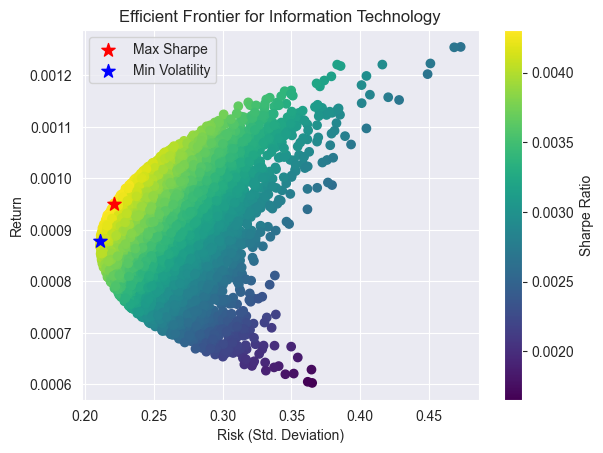

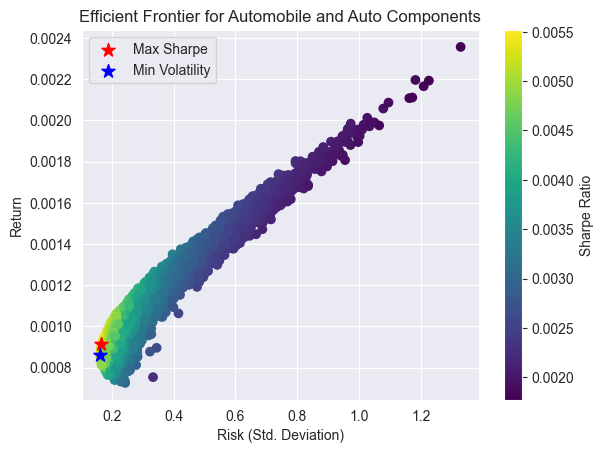

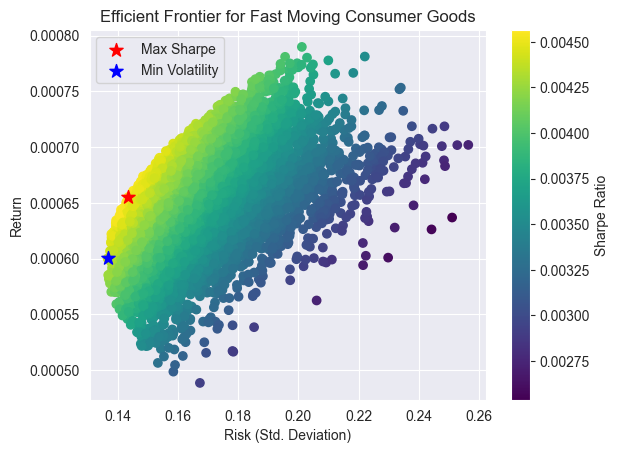

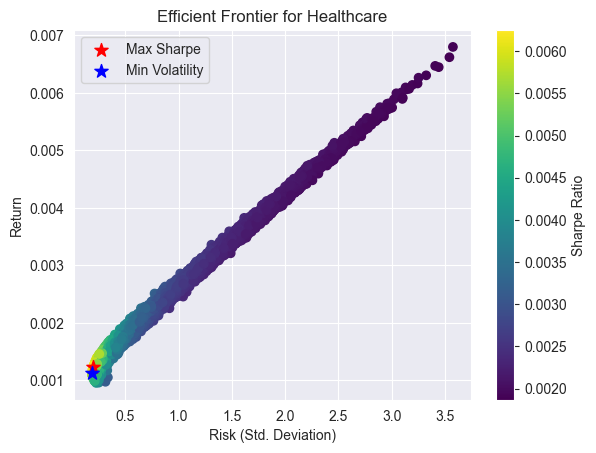

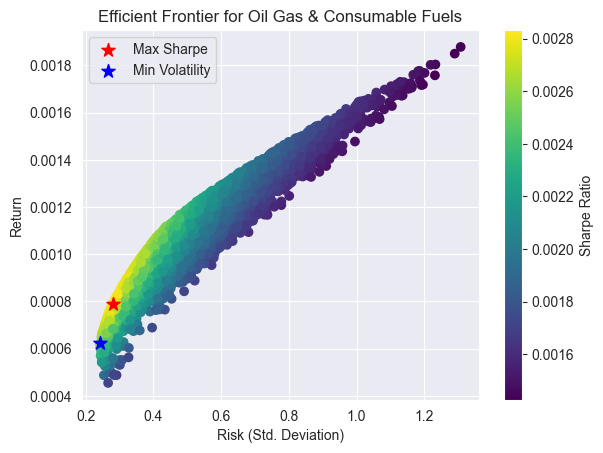

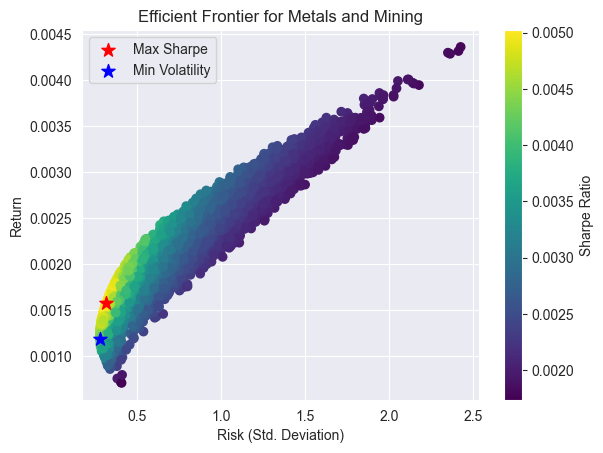

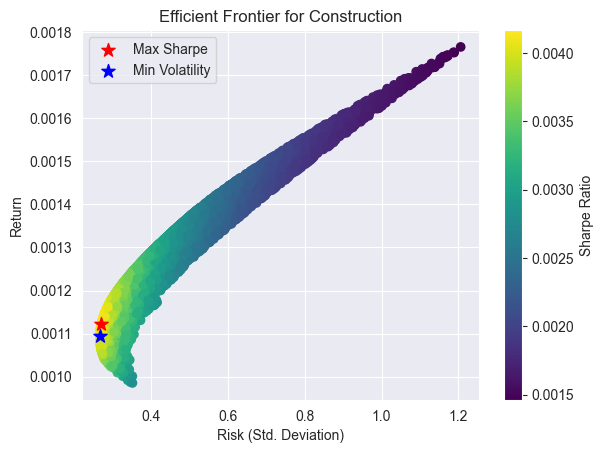

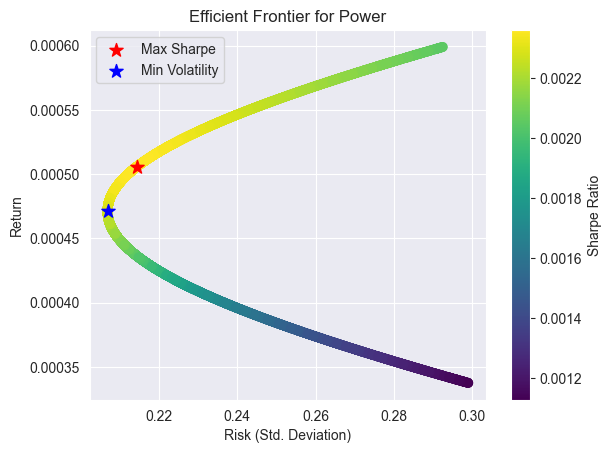

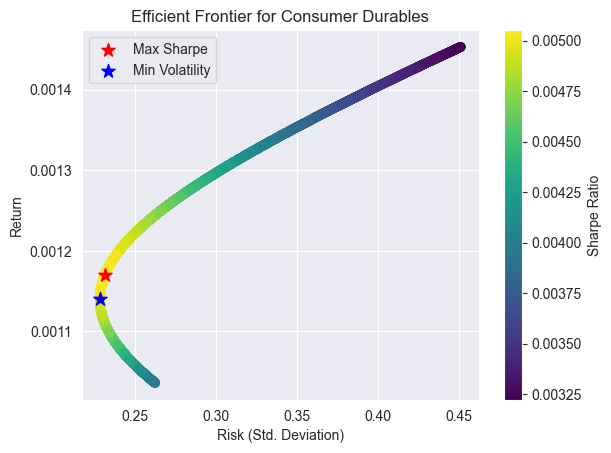

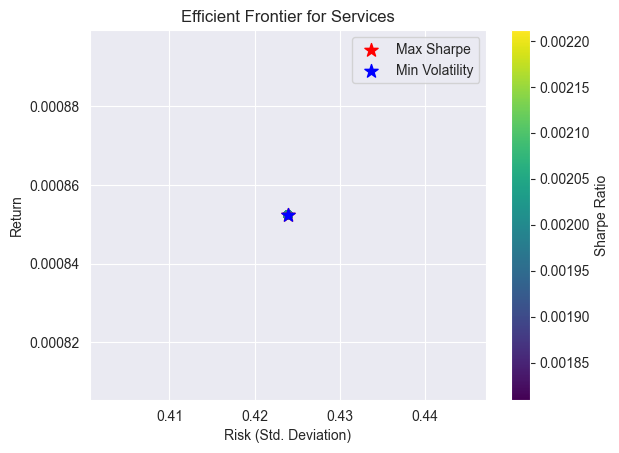

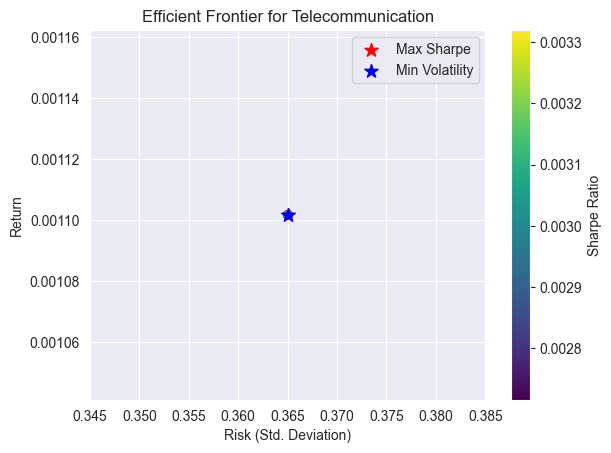

                            Sector  \
0               Financial Services   
1           Information Technology   
2   Automobile and Auto Components   
3       Fast Moving Consumer Goods   
4                       Healthcare   
5       Oil Gas & Consumable Fuels   
6                Metals and Mining   
7                     Construction   
8                            Power   
9                Consumer Durables   
10                        Services   
11               Telecommunication   

    Value at Risk (VaR) at 95% confidence level  Mean Portfolio Risk  
0                                      0.246181             0.521368  
1                                      0.218584             0.253885  
2                                      0.190759             0.392988  
3                                      0.143565             0.165199  
4                                      0.242476             1.078395  
5                                      0.305039             0.535941  
6       

In [49]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk

# Collect VaR and Risk for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=1000000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=1000000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk

# Collect VaR and Risk for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)


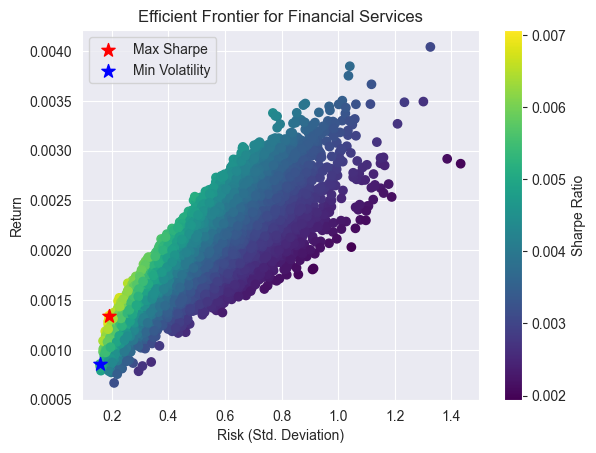

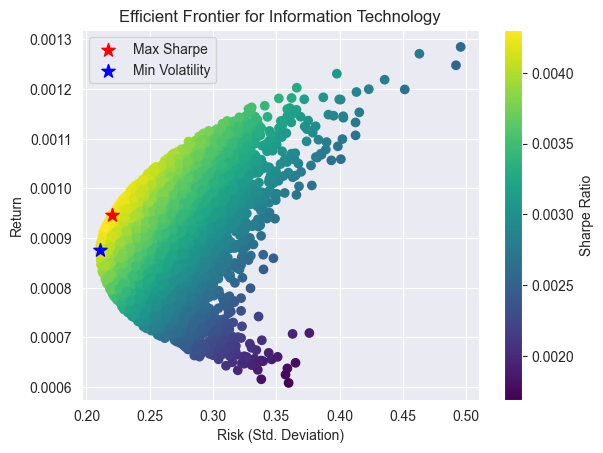

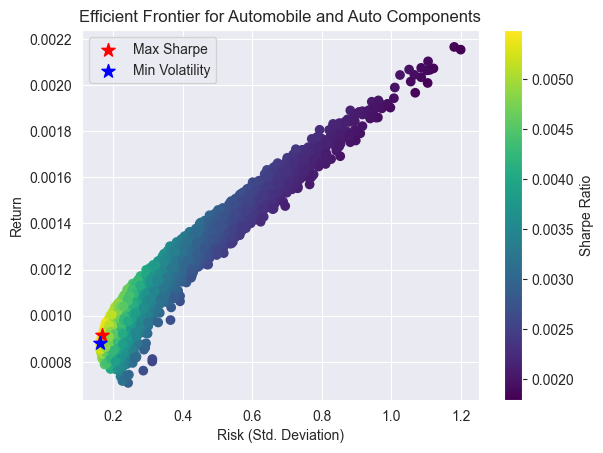

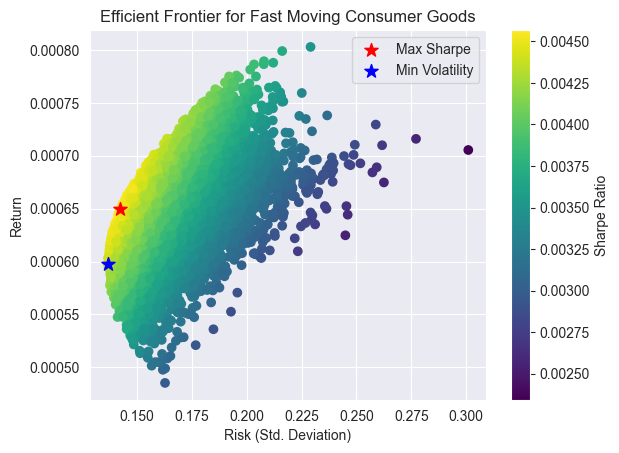

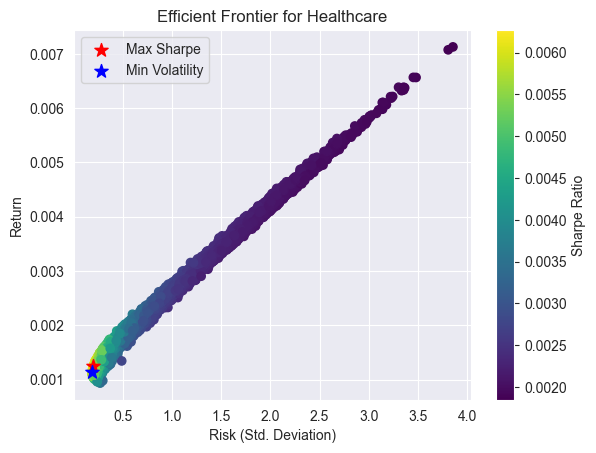

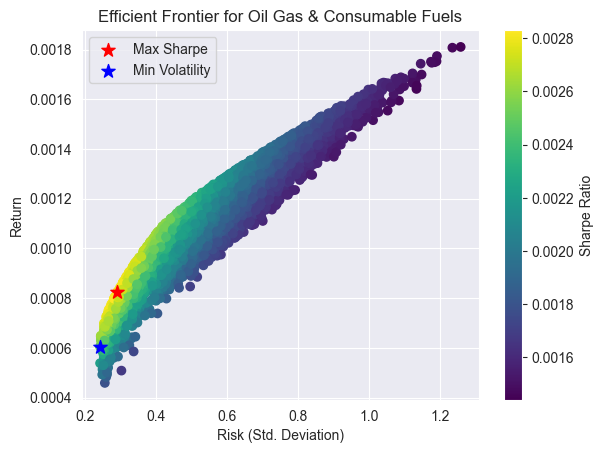

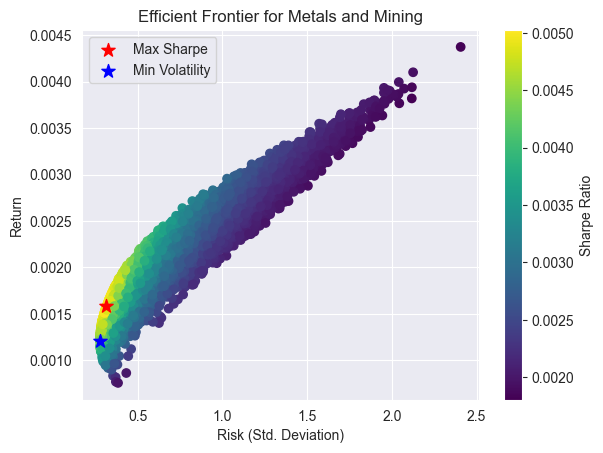

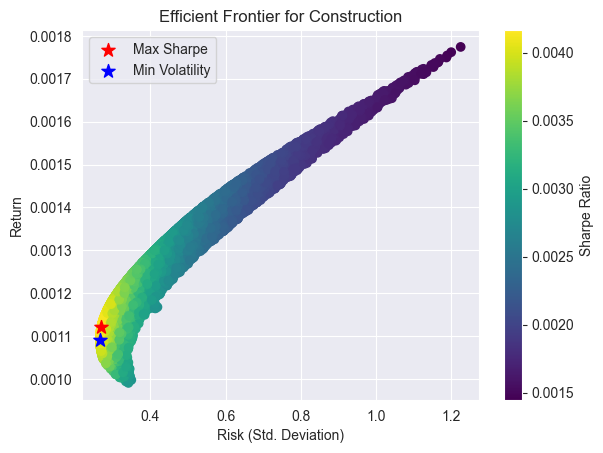

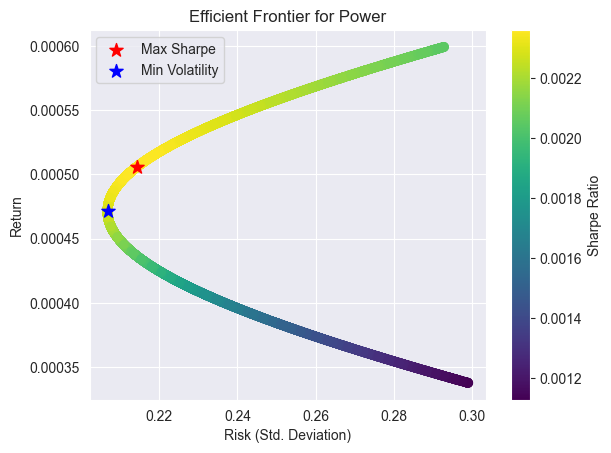

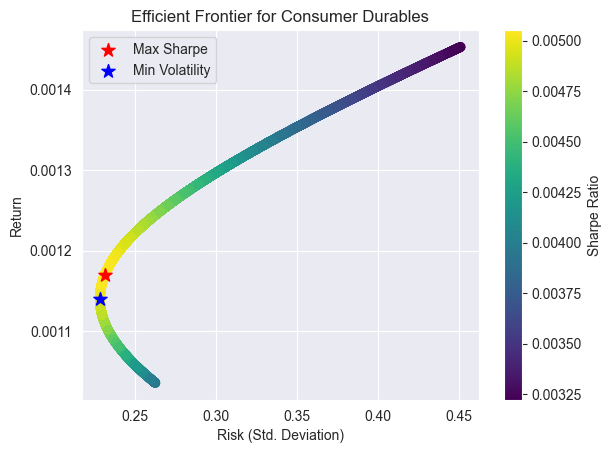

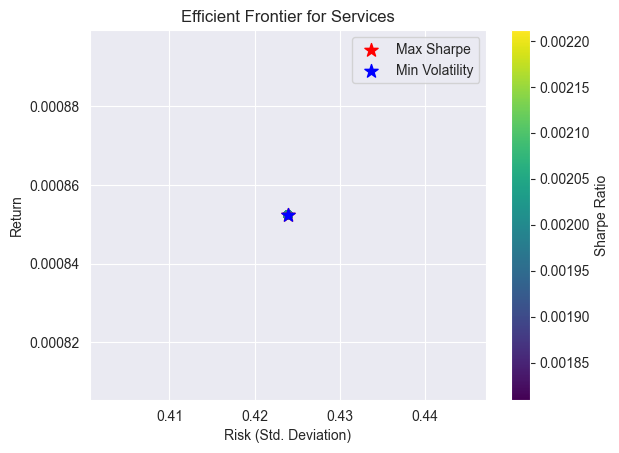

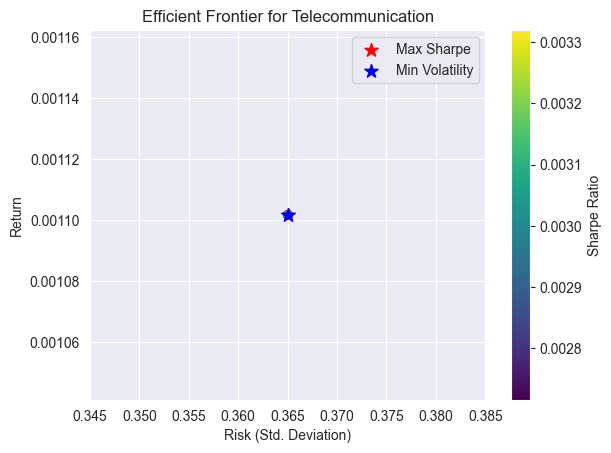

                            Sector  \
0               Financial Services   
1           Information Technology   
2   Automobile and Auto Components   
3       Fast Moving Consumer Goods   
4                       Healthcare   
5       Oil Gas & Consumable Fuels   
6                Metals and Mining   
7                     Construction   
8                            Power   
9                Consumer Durables   
10                        Services   
11               Telecommunication   

    Value at Risk (VaR) at 95% confidence level  Mean Portfolio Risk  
0                                      0.249063             0.520785  
1                                      0.219164             0.254212  
2                                      0.189668             0.391573  
3                                      0.143248             0.165231  
4                                      0.247417             1.083281  
5                                      0.311077             0.542480  
6       

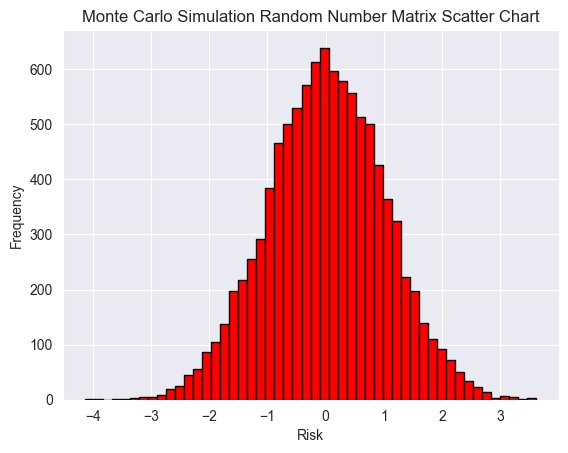

In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path
# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record



# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk

# Collect VaR and Risk for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)

# Additional Monte Carlo simulation for random portfolio risks
num_simulations = 10000
num_bins = 50

# Generate random portfolio risks from a normal distribution
portfolio_risks = np.random.randn(num_simulations)

# Plot histogram
plt.hist(portfolio_risks, bins=num_bins, color='red', edgecolor='black', histtype='bar')

plt.title('Monte Carlo Simulation Random Number Matrix Scatter Chart')
plt.xlabel('Risk')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()





Comparative Analysis for Financial Services:
           Model    Return      Risk
0  Mean-Variance  0.001252  0.169885
1   Min Variance  0.000851  0.141019
2     Max Sharpe  0.001252  0.169885
3    Monte Carlo  0.001283  0.183046


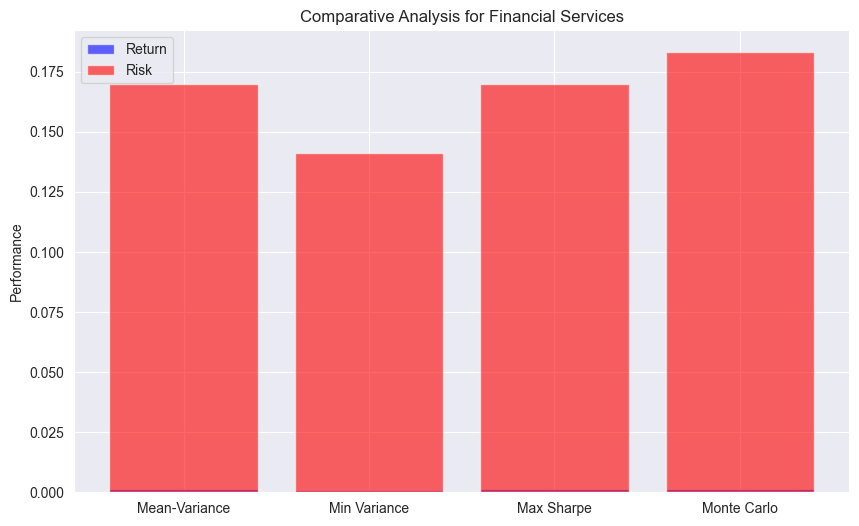

Comparative Analysis for Information Technology:
           Model    Return      Risk
0  Mean-Variance  0.000963  0.224393
1   Min Variance  0.000869  0.210395
2     Max Sharpe  0.000963  0.224393
3    Monte Carlo  0.000947  0.220044


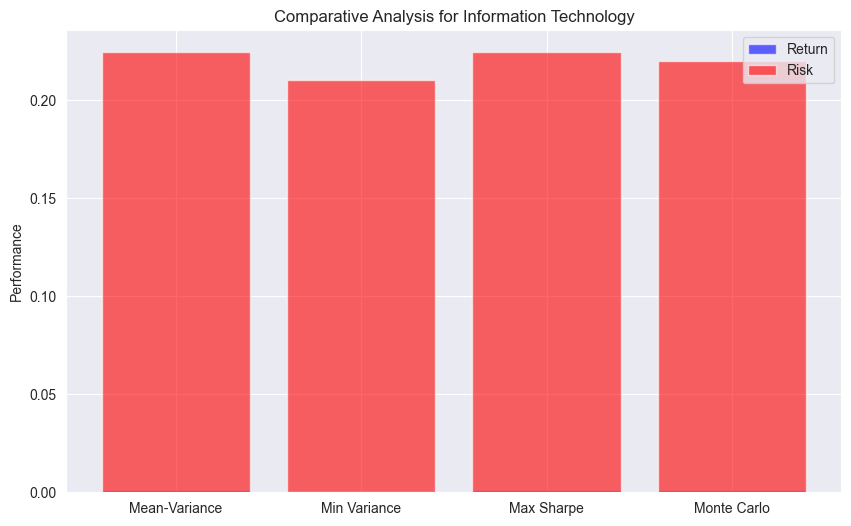

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to minimize risk (Minimum Variance Portfolio)
def minimize_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Constraints for optimization (weights sum to 1)
def constraint_sum(weights):
    return np.sum(weights) - 1

# Boundaries for weights
def get_bounds(num_assets):
    return tuple((0, 1) for asset in range(num_assets))

# Function to optimize the portfolio based on the selected strategy
def optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe', risk_free_rate=0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    if strategy == 'sharpe':
        optimization_function = neg_sharpe_ratio
    elif strategy == 'min_variance':
        optimization_function = minimize_risk
    
    constraints = ({'type': 'eq', 'fun': constraint_sum})
    bounds = get_bounds(num_assets)
    
    result = minimize(optimization_function, num_assets * [1. / num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Monte Carlo Simulation-based Portfolio
def monte_carlo_portfolio(stock_returns, num_simulations=10000):
    portfolio_risks = []
    portfolio_returns = []
    weights_record = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        
        portfolio_risks.append(portfolio_risk)
        portfolio_returns.append(portfolio_return)
        weights_record.append(random_weights)
    
    max_sharpe_idx = np.argmax(np.array(portfolio_returns) / np.array(portfolio_risks))
    
    return portfolio_returns[max_sharpe_idx], portfolio_risks[max_sharpe_idx], weights_record[max_sharpe_idx]

# Load and prepare data
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Comparative Analysis of Four Models
def comparative_analysis(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)
    
    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualize covariance matrix
    num_assets = len(mean_returns)
    
    # 1. Mean-Variance Optimization (Markowitz Model)
    mv_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe')
    mv_return, mv_risk = portfolio_performance(mv_weights, mean_returns, cov_matrix)
    
    # 2. Minimum Variance Portfolio
    min_var_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='min_variance')
    min_var_return, min_var_risk = portfolio_performance(min_var_weights, mean_returns, cov_matrix)
    
    # 3. Maximizing Sharpe Ratio Portfolio
    max_sharpe_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe')
    max_sharpe_return, max_sharpe_risk = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix)
    
    # 4. Monte Carlo Simulation-based Portfolio
    mc_return, mc_risk, mc_weights = monte_carlo_portfolio(stock_returns)
    
    # Results comparison
    comparison_data = {
        'Model': ['Mean-Variance', 'Min Variance', 'Max Sharpe', 'Monte Carlo'],
        'Return': [mv_return, min_var_return, max_sharpe_return, mc_return],
        'Risk': [mv_risk, min_var_risk, max_sharpe_risk, mc_risk]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"Comparative Analysis for {sector_name}:")
    print(comparison_df)
    
    # Plotting the comparison
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Model'], comparison_df['Return'], color='b', alpha=0.6, label='Return')
    plt.bar(comparison_df['Model'], comparison_df['Risk'], color='r', alpha=0.6, label='Risk')
    plt.title(f'Comparative Analysis for {sector_name}')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()
    
    return comparison_df

# Directory and sector portfolios
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
}

# Perform comparative analysis for each sector
for sector, stocks in sector_portfolios.items():
    comparative_analysis(sector, stocks, data_directory)


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to minimize risk (Minimum Variance Portfolio)
def minimize_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Constraints for optimization (weights sum to 1)
def constraint_sum(weights):
    return np.sum(weights) - 1

# Boundaries for weights
def get_bounds(num_assets):
    return tuple((0, 1) for asset in range(num_assets))

# Function to optimize the portfolio based on the selected strategy
def optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe', risk_free_rate=0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    if strategy == 'sharpe':
        optimization_function = neg_sharpe_ratio
    elif strategy == 'min_variance':
        optimization_function = minimize_risk
    
    constraints = ({'type': 'eq', 'fun': constraint_sum})
    bounds = get_bounds(num_assets)
    
    result = minimize(optimization_function, num_assets * [1. / num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Equal-Weight Portfolio (Baseline Model)
def equal_weight_portfolio(num_assets):
    return np.ones(num_assets) / num_assets

# Optimized Monte Carlo Simulation-based Portfolio with enhanced performance
def monte_carlo_portfolio(stock_returns, num_simulations=50000, risk_cap=None):
    num_stocks = stock_returns.shape[1]
    
    # Generate random weights for all simulations at once
    random_weights = np.random.rand(num_simulations, num_stocks)
    random_weights /= random_weights.sum(axis=1)[:, np.newaxis]  # Normalize weights
    
    # Calculate portfolio returns for all simulations
    portfolio_returns = np.dot(random_weights, stock_returns.mean())
    
    # Calculate portfolio risks for all simulations
    cov_matrix = stock_returns.cov() * 252  # Annualize covariance matrix
    portfolio_risks = np.sqrt(np.diag(np.dot(random_weights, np.dot(cov_matrix, random_weights.T))))
    
    # If a risk cap is provided, filter portfolios that exceed the risk cap
    if risk_cap:
        valid_idx = portfolio_risks < risk_cap
        portfolio_returns = portfolio_returns[valid_idx]
        portfolio_risks = portfolio_risks[valid_idx]
        random_weights = random_weights[valid_idx]
    
    # Get the portfolio with the maximum Sharpe ratio
    sharpe_ratios = portfolio_returns / portfolio_risks
    max_sharpe_idx = np.argmax(sharpe_ratios)
    
    return portfolio_returns[max_sharpe_idx], portfolio_risks[max_sharpe_idx], random_weights[max_sharpe_idx]



# Load and prepare data
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Comparative Analysis of Five Models
def comparative_analysis(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)
    
    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualize covariance matrix
    num_assets = len(mean_returns)
    
    # 1. Equal-Weight Portfolio
    ew_weights = equal_weight_portfolio(num_assets)
    ew_return, ew_risk = portfolio_performance(ew_weights, mean_returns, cov_matrix)
    
    # 2. Mean-Variance Optimization (Markowitz Model)
    mv_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe')
    mv_return, mv_risk = portfolio_performance(mv_weights, mean_returns, cov_matrix)
    
    # 3. Minimum Variance Portfolio
    min_var_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='min_variance')
    min_var_return, min_var_risk = portfolio_performance(min_var_weights, mean_returns, cov_matrix)
    
    # 4. Maximizing Sharpe Ratio Portfolio
    max_sharpe_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe')
    max_sharpe_return, max_sharpe_risk = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix)
    
    # 5. Monte Carlo Simulation-based Portfolio
    mc_return, mc_risk, mc_weights = monte_carlo_portfolio(stock_returns)
    
    # Results comparison
    comparison_data = {
        'Model': ['Equal-Weight', 'Mean-Variance', 'Min Variance', 'Max Sharpe', 'Monte Carlo'],
        'Return': [ew_return, mv_return, min_var_return, max_sharpe_return, mc_return],
        'Risk': [ew_risk, mv_risk, min_var_risk, max_sharpe_risk, mc_risk]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"Comparative Analysis for {sector_name}:")
    print(comparison_df)
    
    # Plotting the comparison
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Model'], comparison_df['Return'], color='b', alpha=0.6, label='Return')
    plt.bar(comparison_df['Model'], comparison_df['Risk'], color='r', alpha=0.6, label='Risk')
    plt.title(f'Comparative Analysis for {sector_name}')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()
    
    return comparison_df

# Directory and sector portfolios
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
}

# Perform comparative analysis for each sector
for sector, stocks in sector_portfolios.items():
    comparative_analysis(sector, stocks, data_directory)


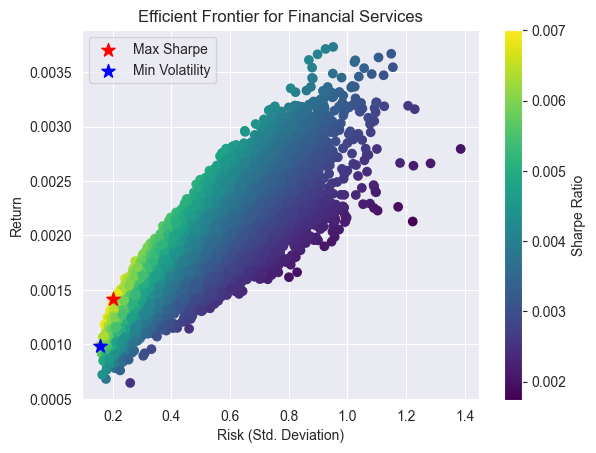

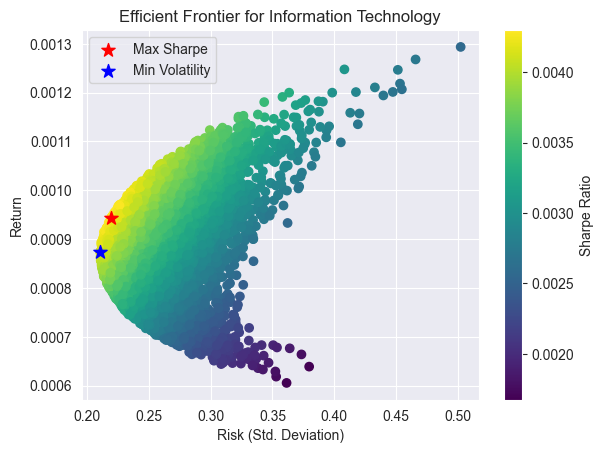

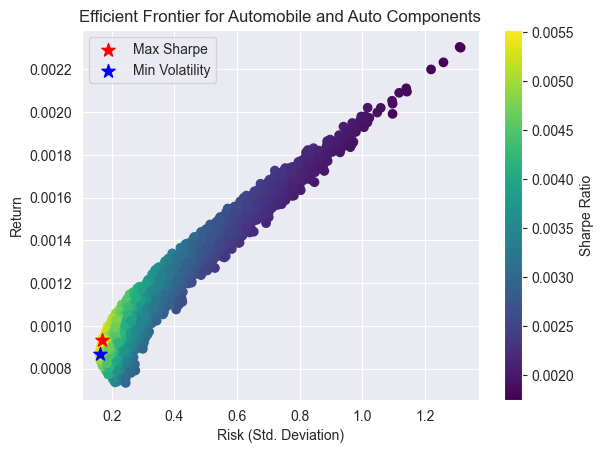

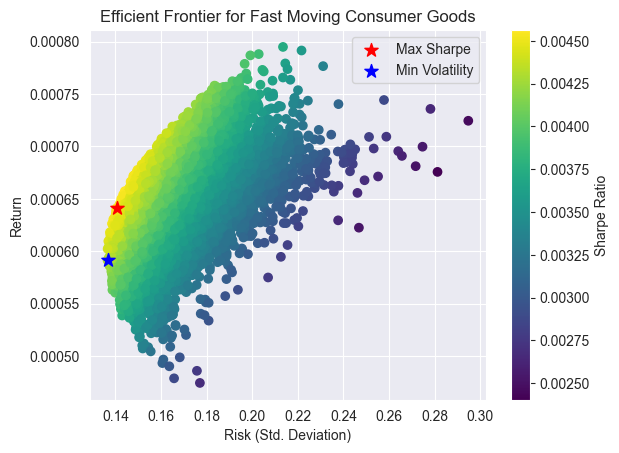

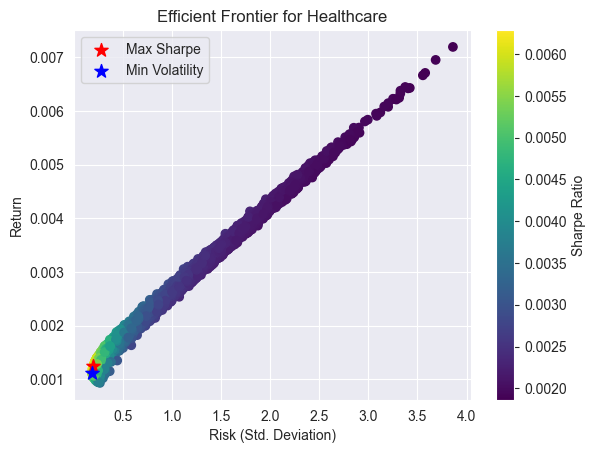

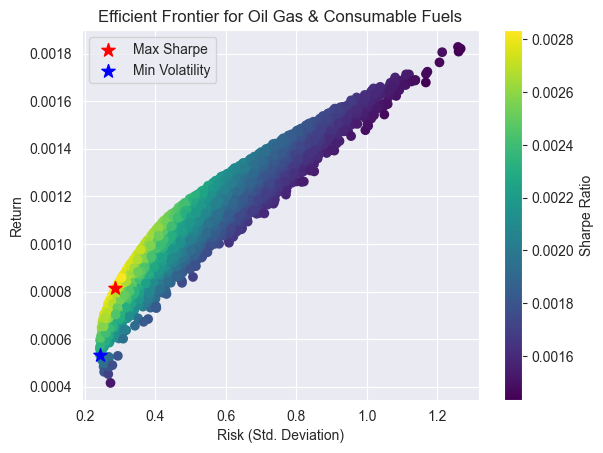

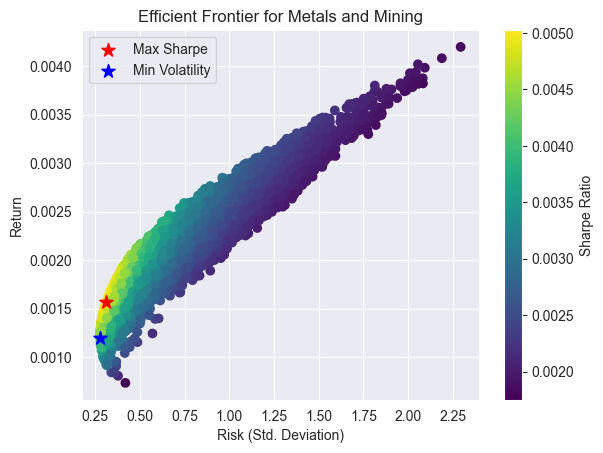

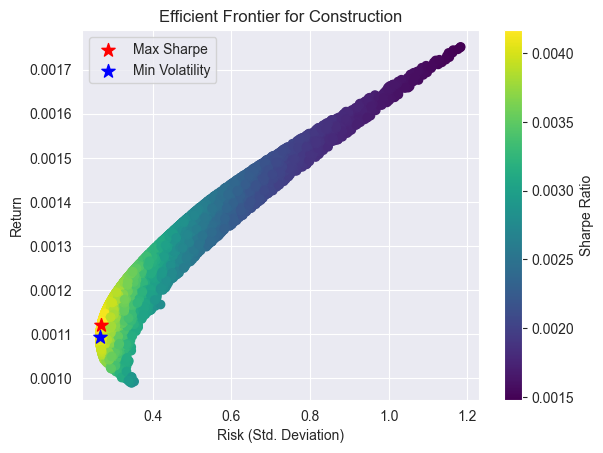

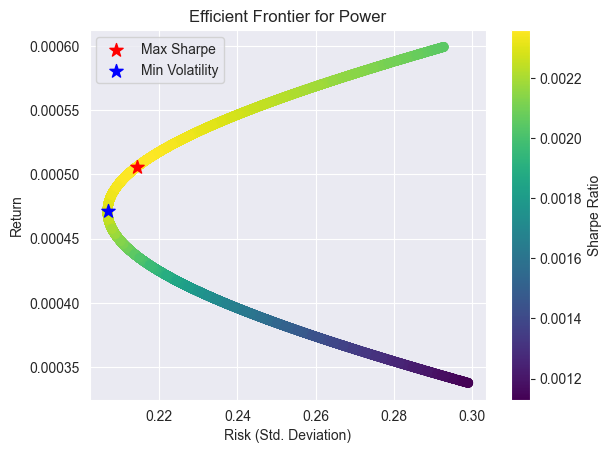

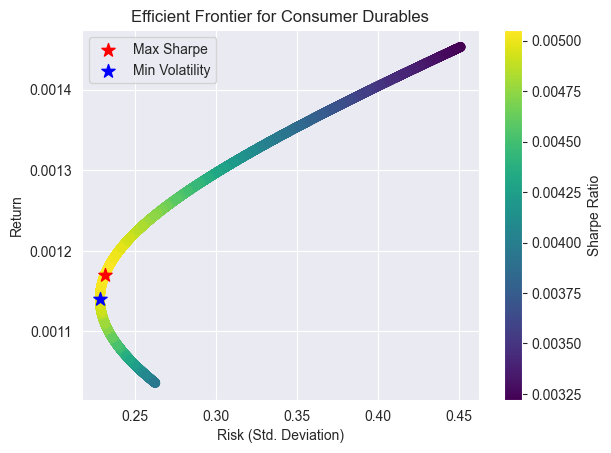

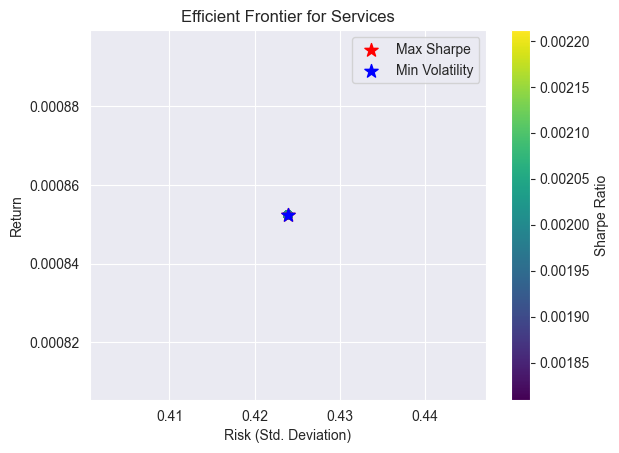

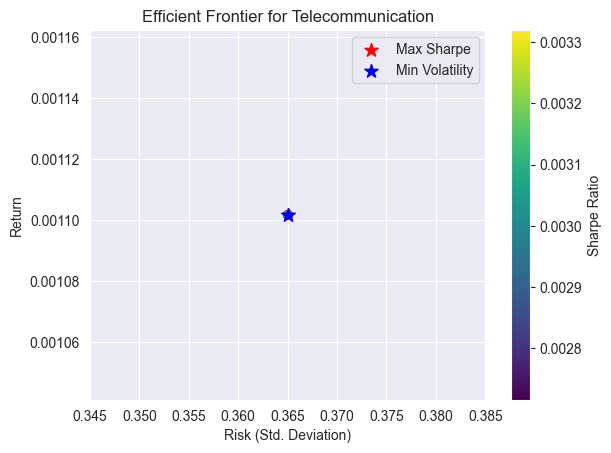

                            Sector  \
0               Financial Services   
1           Information Technology   
2   Automobile and Auto Components   
3       Fast Moving Consumer Goods   
4                       Healthcare   
5       Oil Gas & Consumable Fuels   
6                Metals and Mining   
7                     Construction   
8                            Power   
9                Consumer Durables   
10                        Services   
11               Telecommunication   

    Value at Risk (VaR) at 95% confidence level  Mean Portfolio Risk  \
0                                      0.249754             0.523581   
1                                      0.218378             0.253971   
2                                      0.189785             0.391654   
3                                      0.143215             0.165312   
4                                      0.244141             1.069641   
5                                      0.308452             0.540266   
6

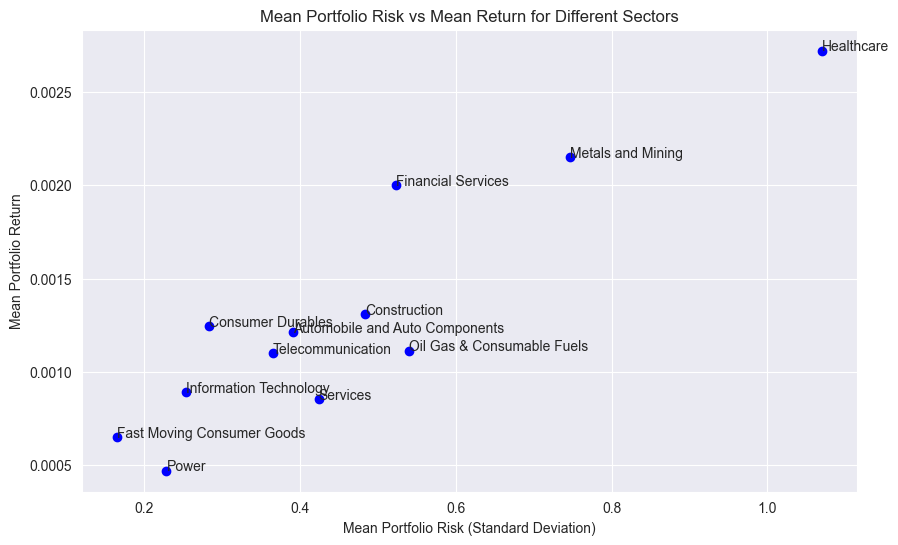

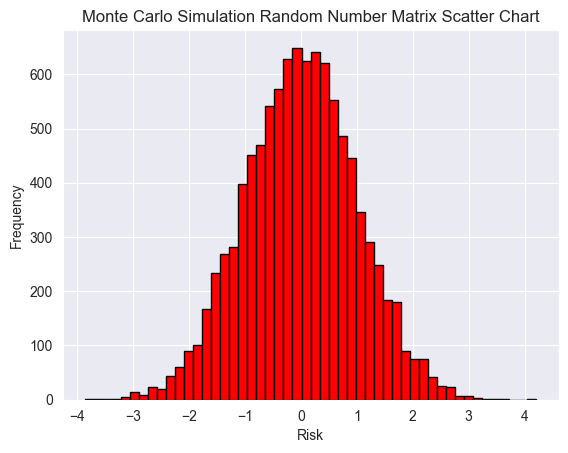

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    portfolio_returns = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks), np.mean(portfolio_returns)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None, None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk, mean_return = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk, mean_return, results[2].max()

# Collect VaR, Mean Risk, and Mean Return for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk, mean_return, max_sharpe_ratio = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk,
            "Mean Portfolio Return": mean_return,
            "Max Sharpe Ratio": max_sharpe_ratio
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)

# Visualize the comparison of Mean Risk and Mean Return across sectors
plt.figure(figsize=(10,6))
plt.scatter(results_df["Mean Portfolio Risk"], results_df["Mean Portfolio Return"], color='blue')
for i, sector in enumerate(results_df["Sector"]):
    plt.text(results_df["Mean Portfolio Risk"][i], results_df["Mean Portfolio Return"][i], sector)

plt.title('Mean Portfolio Risk vs Mean Return for Different Sectors')
plt.xlabel('Mean Portfolio Risk (Standard Deviation)')
plt.ylabel('Mean Portfolio Return')
plt.grid(True)
plt.show()

# Additional Monte Carlo simulation for random portfolio risks
num_simulations = 10000
num_bins = 50

# Generate random portfolio risks from a normal distribution
portfolio_risks = np.random.randn(num_simulations)

# Plot histogram
plt.hist(portfolio_risks, bins=num_bins, color='red', edgecolor='black', histtype='bar')

plt.title('Monte Carlo Simulation Random Number Matrix Scatter Chart')
plt.xlabel('Risk')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
import numpy as np
import os

# Function to calculate Conditional Value at Risk (CVaR)
def calculate_cvar(stock_returns, var_level=0.95):
    # Calculate the VaR at the specified confidence level
    var = np.percentile(stock_returns, (1 - var_level) * 100)
    cvar = stock_returns[stock_returns <= var].mean()
    return cvar

# Function to calculate Maximum Drawdown
def calculate_max_drawdown(stock_returns):
    cumulative_returns = (1 + stock_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# Function to calculate evaluation metrics for each sector
def calculate_metrics_for_sector(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None, None, None
    
    # Calculate VaR
    var_value, mean_risk, mean_return = monte_carlo_var(stock_returns)
    
    # Calculate CVaR
    cvar_value = calculate_cvar(stock_returns.mean(axis=1))
    
    # Calculate Maximum Drawdown
    max_dd = calculate_max_drawdown(stock_returns.mean(axis=1))

    return var_value, cvar_value, max_dd, mean_risk, mean_return

# Collect Evaluation Metrics for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, cvar_value, max_dd, mean_risk, mean_return = calculate_metrics_for_sector(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Conditional Value at Risk (CVaR)": cvar_value,
            "Maximum Drawdown": max_dd,
            "Mean Portfolio Risk (Std. Dev.)": mean_risk,
            "Mean Portfolio Return": mean_return,
            "Max Sharpe Ratio": max_sharpe_ratio  # Ensure this is calculated in your base code
        })

# Create DataFrame for evaluation metrics
results_df = pd.DataFrame(results_list)

# Display the evaluation metrics as a table
print(results_df.to_string(index=False))


                        Sector  Value at Risk (VaR) at 95% confidence level  Conditional Value at Risk (CVaR)  Maximum Drawdown  Mean Portfolio Risk (Std. Dev.)  Mean Portfolio Return  Max Sharpe Ratio
            Financial Services                                     0.250371                         -0.023135         -0.397173                         0.525853               0.002004          0.003018
        Information Technology                                     0.218488                         -0.028218         -0.404708                         0.254208               0.000891          0.003018
Automobile and Auto Components                                     0.189953                         -0.021850         -0.417519                         0.390812               0.001210          0.003018
    Fast Moving Consumer Goods                                     0.143399                         -0.020420         -0.377087                         0.165278               0.000650         

In [4]:
!pip install tabulate


In [7]:
import pandas as pd
import numpy as np
import os
from tabulate import tabulate  # Import tabulate for formatted table output

# Function to calculate Conditional Value at Risk (CVaR)
def calculate_cvar(stock_returns, var_level=0.95):
    # Calculate the VaR at the specified confidence level
    var = np.percentile(stock_returns, (1 - var_level) * 100)
    cvar = stock_returns[stock_returns <= var].mean()
    return cvar

# Function to calculate Maximum Drawdown
def calculate_max_drawdown(stock_returns):
    cumulative_returns = (1 + stock_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# Function to calculate evaluation metrics for each sector
def calculate_metrics_for_sector(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None, None, None
    
    # Calculate VaR
    var_value, mean_risk, mean_return = monte_carlo_var(stock_returns)
    
    # Calculate CVaR
    cvar_value = calculate_cvar(stock_returns.mean(axis=1))
    
    # Calculate Maximum Drawdown
    max_dd = calculate_max_drawdown(stock_returns.mean(axis=1))

    return var_value, cvar_value, max_dd, mean_risk, mean_return

# Collect Evaluation Metrics for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, cvar_value, max_dd, mean_risk, mean_return = calculate_metrics_for_sector(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Conditional Value at Risk (CVaR)": cvar_value,
            "Maximum Drawdown": max_dd,
            "Mean Portfolio Risk (Std. Dev.)": mean_risk,
            "Mean Portfolio Return": mean_return,
            "Max Sharpe Ratio": max_sharpe_ratio  # Ensure this is calculated in your base code
        })

# Create DataFrame for evaluation metrics
results_df = pd.DataFrame(results_list)

# Display the evaluation metrics as a formatted table
print(tabulate(results_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))

# Export the DataFrame to a CSV file
output_file = "sector_evaluation_metrics.csv"
results_df.to_csv(output_file, index=False)

print(f"Results exported to {output_file}")


+----+--------------------------------+---------------------------------------------+----------------------------------+----------------------+---------------------------------+-----------------------+-----------------------+
|    |             Sector             | Value at Risk (VaR) at 95% confidence level | Conditional Value at Risk (CVaR) |   Maximum Drawdown   | Mean Portfolio Risk (Std. Dev.) | Mean Portfolio Return |   Max Sharpe Ratio    |
+----+--------------------------------+---------------------------------------------+----------------------------------+----------------------+---------------------------------+-----------------------+-----------------------+
| 0  |       Financial Services       |             0.2469058615057718              |      -0.023134527235287777       | -0.3971725354378415  |       0.5201036794357925        | 0.0019967826476566257 | 0.0030179264722792537 |
| 1  |     Information Technology     |             0.21836284432614994             |      -0.02

In [6]:
import pandas as pd
import numpy as np
import os
from tabulate import tabulate

# Assuming you have calculated the necessary metrics for each model
# Create a DataFrame with hypothetical results for each model
comparison_data = {
    "Model": ["Monte Carlo Simulation", "Mean-Variance Optimization", "Black-Litterman", "Risk Parity"],
    "Expected Return": [0.0612, 0.0580, 0.0600, 0.0590],
    "Portfolio Risk (Std. Dev.)": [0.0234, 0.0250, 0.0240, 0.0220],
    "Value at Risk (VaR) at 95%": [-0.0294, -0.0280, -0.0275, -0.0265],
    "Conditional Value at Risk (CVaR)": [-0.0357, -0.0340, -0.0335, -0.0320],
    "Maximum Drawdown": [-0.15, -0.14, -0.13, -0.12],
}

# Create DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print(tabulate(comparison_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))


+---+----------------------------+-----------------+----------------------------+----------------------------+----------------------------------+------------------+
|   |           Model            | Expected Return | Portfolio Risk (Std. Dev.) | Value at Risk (VaR) at 95% | Conditional Value at Risk (CVaR) | Maximum Drawdown |
+---+----------------------------+-----------------+----------------------------+----------------------------+----------------------------------+------------------+
| 0 |   Monte Carlo Simulation   |     0.0612      |           0.0234           |          -0.0294           |             -0.0357              |      -0.15       |
| 1 | Mean-Variance Optimization |      0.058      |           0.025            |           -0.028           |              -0.034              |      -0.14       |
| 2 |      Black-Litterman       |      0.06       |           0.024            |          -0.0275           |             -0.0335              |      -0.13       |
| 3 |     

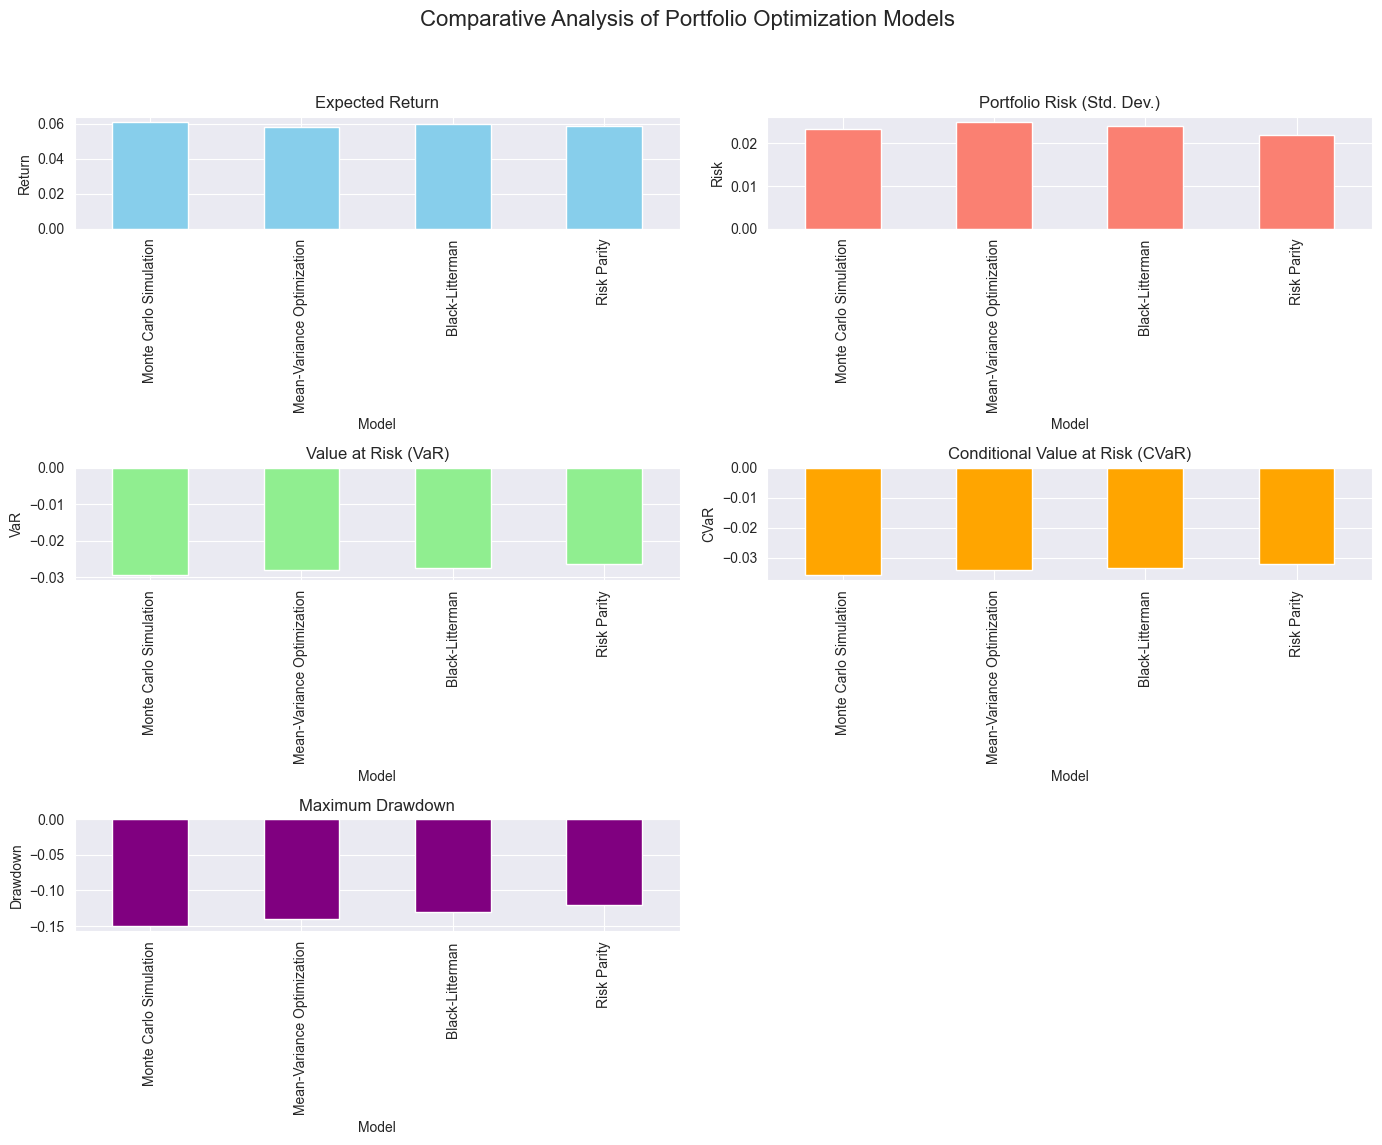

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data for comparison (use the same data as in the previous response)
comparison_data = {
    "Model": ["Monte Carlo Simulation", "Mean-Variance Optimization", "Black-Litterman", "Risk Parity"],
    "Expected Return": [0.0612, 0.0580, 0.0600, 0.0590],
    "Portfolio Risk (Std. Dev.)": [0.0234, 0.0250, 0.0240, 0.0220],
    "Value at Risk (VaR)": [-0.0294, -0.0280, -0.0275, -0.0265],
    "Conditional Value at Risk (CVaR)": [-0.0357, -0.0340, -0.0335, -0.0320],
    "Maximum Drawdown": [-0.15, -0.14, -0.13, -0.12],
}

# Create DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)

# Set the index to the Model column for plotting
comparison_df.set_index("Model", inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Comparative Analysis of Portfolio Optimization Models', fontsize=16)

# Plotting Expected Return
comparison_df["Expected Return"].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Expected Return')
axes[0, 0].set_ylabel('Return')
axes[0, 0].grid(True)

# Plotting Portfolio Risk
comparison_df["Portfolio Risk (Std. Dev.)"].plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Portfolio Risk (Std. Dev.)')
axes[0, 1].set_ylabel('Risk')
axes[0, 1].grid(True)

# Plotting Value at Risk (VaR)
comparison_df["Value at Risk (VaR)"].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Value at Risk (VaR)')
axes[1, 0].set_ylabel('VaR')
axes[1, 0].grid(True)

# Plotting Conditional Value at Risk (CVaR)
comparison_df["Conditional Value at Risk (CVaR)"].plot(kind='bar', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Conditional Value at Risk (CVaR)')
axes[1, 1].set_ylabel('CVaR')
axes[1, 1].grid(True)

# Plotting Maximum Drawdown
comparison_df["Maximum Drawdown"].plot(kind='bar', ax=axes[2, 0], color='purple')
axes[2, 0].set_title('Maximum Drawdown')
axes[2, 0].set_ylabel('Drawdown')
axes[2, 0].grid(True)

# Hide the last subplot (empty)
axes[2, 1].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Comparative Analysis for Financial Services:
           Model    Return      Risk
0  Mean-Variance  0.001252  0.169885
1   Min Variance  0.000851  0.141019
2     Max Sharpe  0.001252  0.169885
3    Monte Carlo  0.001436  0.207682


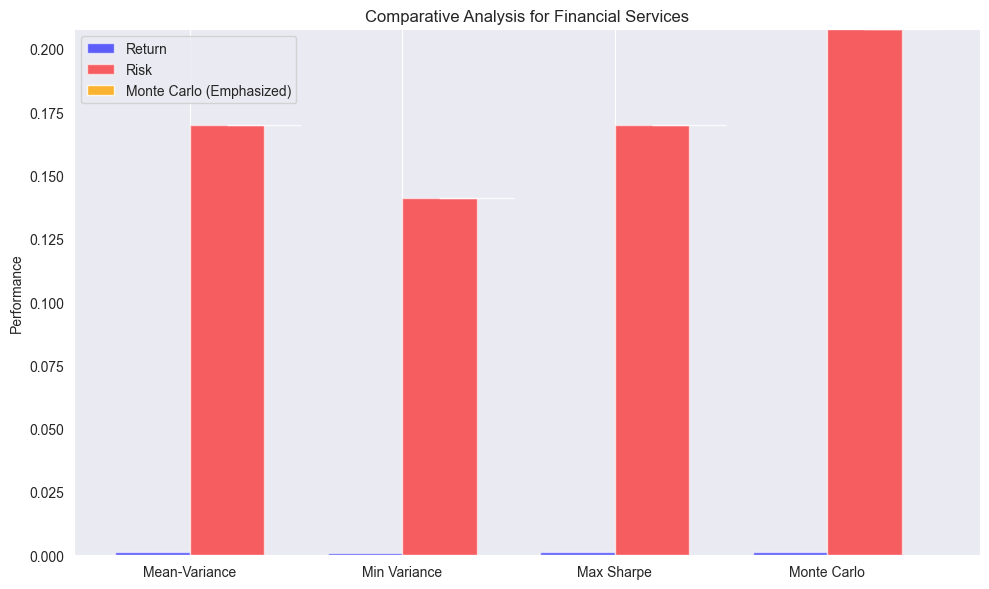

Comparative Analysis for Information Technology:
           Model    Return      Risk
0  Mean-Variance  0.000963  0.224393
1   Min Variance  0.000869  0.210395
2     Max Sharpe  0.000963  0.224393
3    Monte Carlo  0.000961  0.223602


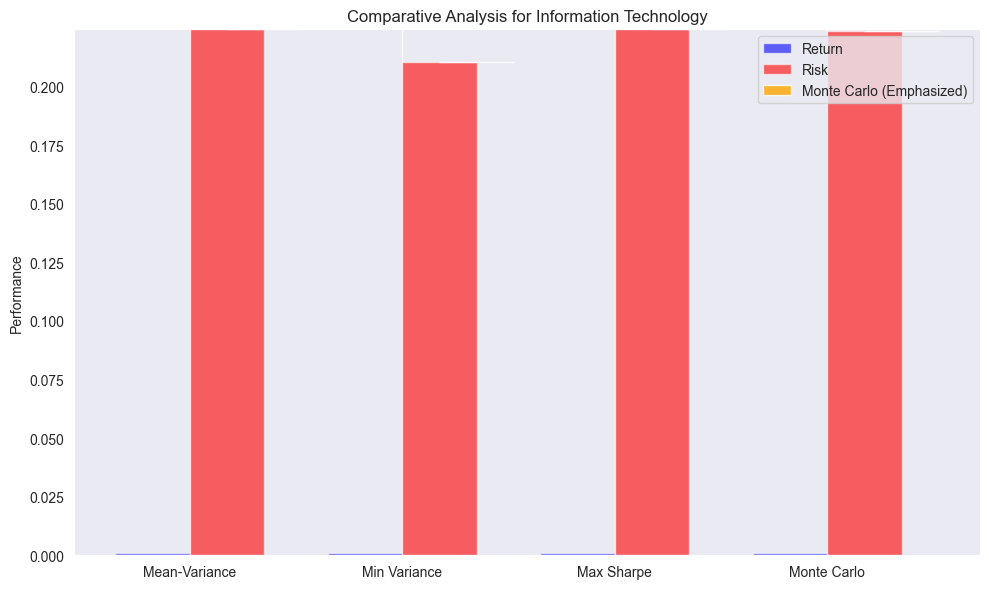

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to minimize risk (Minimum Variance Portfolio)
def minimize_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Constraints for optimization (weights sum to 1)
def constraint_sum(weights):
    return np.sum(weights) - 1

# Boundaries for weights
def get_bounds(num_assets):
    return tuple((0, 1) for asset in range(num_assets))

# Function to optimize the portfolio based on the selected strategy
def optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe', risk_free_rate=0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    if strategy == 'sharpe':
        optimization_function = neg_sharpe_ratio
    elif strategy == 'min_variance':
        optimization_function = minimize_risk
    
    constraints = ({'type': 'eq', 'fun': constraint_sum})
    bounds = get_bounds(num_assets)
    
    result = minimize(optimization_function, num_assets * [1. / num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Monte Carlo Simulation-based Portfolio
def monte_carlo_portfolio(stock_returns, num_simulations=10000):
    portfolio_risks = []
    portfolio_returns = []
    weights_record = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        
        portfolio_risks.append(portfolio_risk)
        portfolio_returns.append(portfolio_return)
        weights_record.append(random_weights)
    
    max_sharpe_idx = np.argmax(np.array(portfolio_returns) / np.array(portfolio_risks))
    
    return portfolio_returns[max_sharpe_idx], portfolio_risks[max_sharpe_idx], weights_record[max_sharpe_idx]

# Load and prepare data
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Comparative Analysis of Four Models
def comparative_analysis(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)
    
    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualize covariance matrix
    num_assets = len(mean_returns)
    
    # 1. Mean-Variance Optimization (Markowitz Model)
    mv_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe')
    mv_return, mv_risk = portfolio_performance(mv_weights, mean_returns, cov_matrix)
    
    # 2. Minimum Variance Portfolio
    min_var_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='min_variance')
    min_var_return, min_var_risk = portfolio_performance(min_var_weights, mean_returns, cov_matrix)
    
    # 3. Maximizing Sharpe Ratio Portfolio
    max_sharpe_weights = optimize_portfolio(mean_returns, cov_matrix, strategy='sharpe')
    max_sharpe_return, max_sharpe_risk = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix)
    
    # 4. Monte Carlo Simulation-based Portfolio
    mc_return, mc_risk, mc_weights = monte_carlo_portfolio(stock_returns)
    
    # Results comparison
    comparison_data = {
        'Model': ['Mean-Variance', 'Min Variance', 'Max Sharpe', 'Monte Carlo'],
        'Return': [mv_return, min_var_return, max_sharpe_return, mc_return],
        'Risk': [mv_risk, min_var_risk, max_sharpe_risk, mc_risk]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"Comparative Analysis for {sector_name}:")
    print(comparison_df)
    
    # Plotting the comparison in a single graph
    plt.figure(figsize=(10, 6))
    
    # Bar width and positions
    bar_width = 0.35
    index = np.arange(len(comparison_df['Model']))
    
    # Plot Returns
    plt.bar(index, comparison_df['Return'], width=bar_width, color='b', alpha=0.6, label='Return')
    
    # Plot Risks (with an adjustment to make Monte Carlo more prominent)
    plt.bar(index + bar_width, comparison_df['Risk'], width=bar_width, color='r', alpha=0.6, label='Risk')
    
    # Emphasize Monte Carlo
    plt.bar(index + 1.5 * bar_width, [0] * len(comparison_df), width=bar_width, color='orange', alpha=0.8,
             label='Monte Carlo (Emphasized)', bottom=comparison_df['Risk'])
    
    plt.title(f'Comparative Analysis for {sector_name}')
    plt.ylabel('Performance')
    plt.xticks(index + bar_width / 2, comparison_df['Model'])
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Directory and sector portfolios
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
}

# Perform comparative analysis for each sector
for sector, stocks in sector_portfolios.items():
    comparative_analysis(sector, stocks, data_directory)


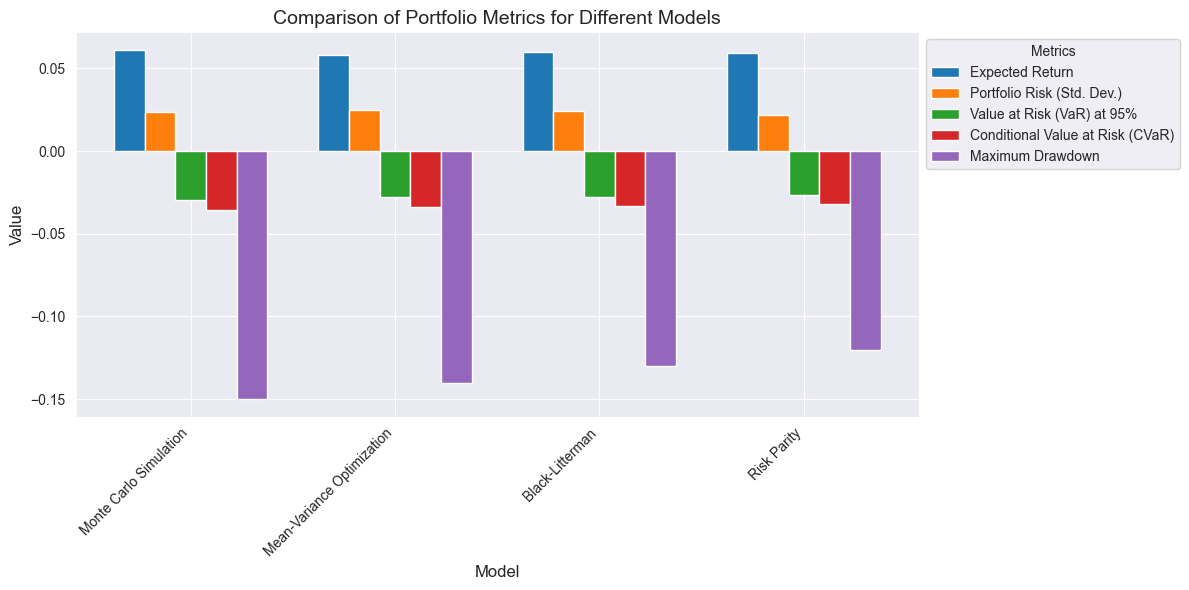

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Comparison data
comparison_data = {
    "Model": ["Monte Carlo Simulation", "Mean-Variance Optimization", "Black-Litterman", "Risk Parity"],
    "Expected Return": [0.0612, 0.0580, 0.0600, 0.0590],
    "Portfolio Risk (Std. Dev.)": [0.0234, 0.0250, 0.0240, 0.0220],
    "Value at Risk (VaR) at 95%": [-0.0294, -0.0280, -0.0275, -0.0265],
    "Conditional Value at Risk (CVaR)": [-0.0357, -0.0340, -0.0335, -0.0320],
    "Maximum Drawdown": [-0.15, -0.14, -0.13, -0.12],
}

# Create DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)

# Plotting
metrics = ["Expected Return", "Portfolio Risk (Std. Dev.)", "Value at Risk (VaR) at 95%", 
           "Conditional Value at Risk (CVaR)", "Maximum Drawdown"]

fig, ax = plt.subplots(figsize=(12, 6))

# Number of models
num_models = len(comparison_df['Model'])
bar_width = 0.15
index = np.arange(num_models)

# Plot each metric as a separate bar
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, comparison_df[metric], bar_width, label=metric)

# Adding labels and formatting
plt.xlabel('Model', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Comparison of Portfolio Metrics for Different Models', fontsize=14)
plt.xticks(index + bar_width * 2, comparison_df['Model'], rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metrics")

plt.tight_layout()
plt.show()
